<a href="https://colab.research.google.com/github/DeanKW/gutenberg_corpus_analysis/blob/main/Cleaned_PreTrained_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os, sys

from collections import Counter
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import Dataset
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer
import scipy.special
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from transformers import AutoConfig
import joblib
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DefaultDataCollator
)
from dataclasses import dataclass
import shutil
import os
import gc
import functools
from google.colab import drive
import copy

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.5 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import optuna.exceptions

In [ ]:
# from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# memory checker
if torch.cuda.is_available():

    device = torch.cuda.current_device()
    gpu_properties = torch.cuda.get_device_properties(device)


    total_memory = gpu_properties.total_memory / 1e9
    allocated_memory = torch.cuda.memory_allocated() / 1e9
    free_memory = total_memory - allocated_memory


    reserved_memory = torch.cuda.memory_reserved() / 1e9

    print(f"GPU: {gpu_properties.name}")
    print(f"Total memory: {total_memory:.2f} GB")
    print(f"Allocated memory: {allocated_memory:.2f} GB")
    print(f"Free memory: {free_memory:.2f} GB")
    print(f"Reserved memory: {reserved_memory:.2f} GB")
else:
    print("CUDA not available. Running on CPU.")

GPU: Tesla T4
Total memory: 15.83 GB
Allocated memory: 15.39 GB
Free memory: 0.43 GB
Reserved memory: 15.65 GB


In [ ]:
# Create local directory
!mkdir -p /content/local_text_files

# Copy all files directly
!cp -r "/content/drive/MyDrive/TheoryofML_GroupProject/externalities/gutenberg/data/text/"* /content/local_text_files/

print("Files copied locally. Now reading will be much faster!")

Files copied locally. Now reading will be much faster!


In [ ]:
gdrive_path = "/content/drive/MyDrive/TheoryofML_GroupProject/externalities"

In [ ]:
## path to the downloaded gutenberg corpus
path_gutenberg = os.path.join(gdrive_path,'gutenberg')

In [ ]:
path_gutenberg

'/content/drive/MyDrive/TheoryofML_GroupProject/externalities/gutenberg'

In [ ]:
# get the updated csv
# data_path = os.path.join(os.pardir, 'sample_dataset')
train_path = os.path.join(gdrive_path,os.pardir, 'final_train.csv')
test_path = os.path.join(gdrive_path,os.pardir, 'final_test.csv')
val_path = os.path.join(gdrive_path,os.pardir, 'final_val.csv')

In [ ]:
train_meta_df = pd.read_csv(train_path)
test_meta_df = pd.read_csv(test_path)
val_meta_df = pd.read_csv(val_path)

In [ ]:
val_meta_df.head()

,Unnamed: 0.1,Unnamed: 0,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects
0,0,403,PG10567,"The Guardian Angel: Ship's Company, Part 7.","Jacobs, W. W. (William Wymark)",1863.0,1943.0,['en'],94,"{'Humorous stories, English', 'England -- Soci..."
1,9,1247,PG11476,"Husbandry: Deep Waters, Part 6.","Jacobs, W. W. (William Wymark)",1863.0,1943.0,['en'],129,"{'Humorous stories, English', 'Sailors -- Fict..."
2,74,10009,PG21927,Short Cruises,"Jacobs, W. W. (William Wymark)",1863.0,1943.0,['en'],218,"{'River life -- Fiction', 'Humorous stories, E..."
3,73,9704,PG215,The call of the wild,"London, Jack",1876.0,1916.0,['en'],6642,"{'Dogs -- Fiction', 'Sled dogs -- Fiction', 'F..."
4,1,406,PG1056,Martin Eden,"London, Jack",1876.0,1916.0,['en'],2658,"{'Working class -- Fiction', 'Authors -- Ficti..."


In [ ]:
val_meta_df['subjects']

,subjects
0,"{'Humorous stories, English', 'England -- Soci..."
1,"{'Humorous stories, English', 'Sailors -- Fict..."
2,"{'River life -- Fiction', 'Humorous stories, E..."
3,"{'Dogs -- Fiction', 'Sled dogs -- Fiction', 'F..."
4,"{'Working class -- Fiction', 'Authors -- Ficti..."
...,...
235,"{'Technology -- Fiction', 'Science fiction', '..."
236,"{'Science fiction', 'Multiple personality -- F..."
237,"{'Granada (Spain) -- History -- Siege, 1491-14..."
238,"{'Good and evil', 'Religion', 'Free thought'}"


In [ ]:
val_meta_df['author'].nunique(),test_meta_df['author'].nunique(),train_meta_df['author'].nunique()

(80, 80, 80)

In [ ]:
def get_book_fast(id, path_gutenberg=None, level='text'):
    """Modified get_book that uses local files first"""
    # Try local path first
    local_path = f"/content/local_text_files/{id}_text.txt"

    if os.path.exists(local_path):
        with open(local_path, 'r', encoding='utf-8', errors='replace') as f:
            return f.read()
    else:
        # Fall back to original path if not found locally
        original_path = f"{path_gutenberg}/data/{level}/{id}_text.txt"
        with open(original_path, 'r', encoding='utf-8', errors='replace') as f:
            return f.read()

In [ ]:
os.path.exists(f"{path_gutenberg}/data/text/PG75760_text.txt")

True

#Chunking and Aggregating

In [ ]:
# make combined sampling function including global attention for longformer


def get_token_samples_multiple(path_gutenberg, num_samples_list, meta_df, tokenizer, max_length=512,
                               existing_label_to_id=None, use_global_attention=False, strip_tokens=100):
    '''Get samples for multiple num_samples_per_book values efficiently
    Takes samles from end of book only. Strips first 100 tokens (remove author name and book title)
    Args:
        existing_label_to_id: put  train label to id here
        use_global_attention: for Longformer!!

    '''
    # Find the maximum number of samples needed
    max_num_samples = max(num_samples_list)

    # Dictionary to track samples by author and book
    book_samples = {}  # Dict of authors -> dict of book_ids -> list of samples

    # For each author
    for author in meta_df['author'].unique():
        author_df = meta_df.loc[meta_df['author'] == author]
        book_samples[author] = {}

        # For each book
        for id in author_df['id'].unique():
            try:
                book_str = get_book_fast(id, path_gutenberg=path_gutenberg, level='text')
            except FileNotFoundError:
                print(f"{id} missing for author {author}")
                continue

            # Tokenize full text once
            tokens_dict = tokenizer(book_str, truncation=False, return_tensors="pt")
            tokens = tokens_dict["input_ids"][0]
            masks = tokens_dict["attention_mask"][0]

            # Strip first N tokens
            if strip_tokens > 0:
                tokens = tokens[strip_tokens:]
                masks = masks[strip_tokens:]

            # Calculate tokens needed for max samples
            total_tokens_needed = max_num_samples * max_length

            # If the book is too short pad
            if len(tokens) < total_tokens_needed:
                while len(tokens) < total_tokens_needed:
                    tokens = torch.cat([tokens, tokens])
                    masks = torch.cat([masks, masks])

            # Take the last total_tokens_needed tokens
            last_n_tokens = tokens[-total_tokens_needed:]
            last_n_masks = masks[-total_tokens_needed:]

            # Create samples for this book
            samples_for_book = []
            for sample_num in range(max_num_samples):
                start_idx = sample_num * max_length
                end_idx = start_idx + max_length

                sample = last_n_tokens[start_idx:end_idx].tolist()
                attention_mask = last_n_masks[start_idx:end_idx].tolist()

                if use_global_attention and len(attention_mask) > 0:
                    # Add global attention to first token for Longformer
                    global_attention_mask = [0] * len(attention_mask)
                    global_attention_mask[0] = 1  # Set global attention on CLS token
                    samples_for_book.append((sample, attention_mask, global_attention_mask))
                else:
                    if use_global_attention:
                        # Empty but consistent tuple structure
                        samples_for_book.append((sample, attention_mask, []))
                    else:
                        # Original tuple structure without global attention
                        samples_for_book.append((sample, attention_mask))

            # Store all samples for this book
            book_samples[author][id] = samples_for_book

    # Create the label mapping or use existing one
    if existing_label_to_id is None:
        label_to_id = {author: idx for idx, author in enumerate(book_samples.keys())}
    else:
        label_to_id = existing_label_to_id

    # Process each num_samples_per_book value
    results = {}
    for num_samples in num_samples_list:
        all_samples = []
        all_masks = []
        all_global_attention_masks = [] if use_global_attention else None
        all_labels = []
        all_doc_ids = []

        for author, books in book_samples.items():
            if author not in label_to_id:
                print(f"Warning: Author '{author}' not found in label_to_id mapping, skipping")
                continue

            label_id = label_to_id[author]

            # For each book of this author
            for book_id, book_sample_list in books.items():
                # Take the last num_samples samples from this book
                samples_to_take = min(num_samples, len(book_sample_list))
                selected_samples = book_sample_list[-samples_to_take:]

                # Add to  collections
                if use_global_attention:
                    for sample, mask, global_attention in selected_samples:
                        all_samples.append(sample)
                        all_masks.append(mask)
                        all_global_attention_masks.append(global_attention)
                        all_labels.append(label_id)
                        all_doc_ids.append(book_id)
                else:
                    for sample, mask in selected_samples:
                        all_samples.append(sample)
                        all_masks.append(mask)
                        all_labels.append(label_id)
                        all_doc_ids.append(book_id)

        # Convert to tensors
        samples_tensor = torch.tensor(all_samples)
        masks_tensor = torch.tensor(all_masks)
        labels_tensor = torch.tensor(all_labels)

        # Store in results
        if use_global_attention:
            global_attention_tensor = torch.tensor(all_global_attention_masks)
            results[num_samples] = (
                samples_tensor,
                masks_tensor,
                global_attention_tensor,
                labels_tensor,
                all_doc_ids
            )
        else:
            results[num_samples] = (
                samples_tensor,
                masks_tensor,
                labels_tensor,
                all_doc_ids
            )

    return results, label_to_id

In [ ]:
model_ckpt = "distilbert-base-uncased"
# model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
path_gutenberg

'/content/drive/MyDrive/TheoryofML_GroupProject/externalities/gutenberg'

In [ ]:
num_samples_list = [5,10,15,20,25,30]
max_length = 512 #DistilBert specific

In [ ]:
results_train,label_to_id_train = get_token_samples_multiple(
                            path_gutenberg,
                            num_samples_list,
                            train_meta_df,
                            tokenizer,
                            max_length)

Token indices sequence length is longer than the specified maximum sequence length for this model (62762 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
num_samples_list = [5,10,15,20,25,30,40,50,60,100,150,200,300,500,700,1000,2000]
max_length = 512 #DistilBert specific

In [ ]:
results_val_ext,label_to_id_val_ext = get_token_samples_multiple(
                            path_gutenberg,
                            num_samples_list,
                            val_meta_df,
                            tokenizer,
                            max_length,
                            existing_label_to_id=label_to_id_train)

In [ ]:
results_test,label_to_id_test = get_token_samples_multiple(
                            path_gutenberg,
                            num_samples_list,
                            test_meta_df,
                            tokenizer,
                            max_length,
                            existing_label_to_id=label_to_id_train)

In [ ]:
label_to_id_val_ext == label_to_id_train

True

In [ ]:
# first load label_to_id_val

In [ ]:
def save_tokenized_data(data, filename, save_to_drive=True):

  '''now saves all in BERT folder'''
  # Save locally (for current session)
  local_path = f"/content/{filename}.pkl"
  with open(local_path, 'wb') as f:
      pickle.dump(data, f)

  # Also save to Drive
  if save_to_drive:
      drive_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/{filename}.pkl"
      # Create directory if it doesn't exist
      os.makedirs(os.path.dirname(drive_path), exist_ok=True)
      with open(drive_path, 'wb') as f:
          pickle.dump(data, f)


In [ ]:
save_tokenized_data((results_train, label_to_id_train), "train_tokenized_data")



In [ ]:
save_tokenized_data((results_val_ext, label_to_id_val_ext), "val_tokenized_data_ext")

In [ ]:
save_tokenized_data((results_val_ext, label_to_id_val_ext), "test_tokenized_data_ext")

In [ ]:
label_to_id_val == label_to_id_train # check should be True

True

In [ ]:
def load_pickel_data(filepath):
   with open(filepath, 'rb') as f:
    data = pickle.load(f)
    return data

In [ ]:
filepath = f"/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/train_tokenized_data.pkl"
results_train, label_to_id_train = load_pickel_data(filepath)


KeyboardInterrupt: 

In [ ]:
filepath = f"/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/val_tokenized_data.pkl"
results_val, label_to_id_val = load_pickel_data(filepath)

In [ ]:
label_to_id_train = copy.deepcopy(label_to_id_val)


In [ ]:
# print(f"train_samples: {sys.getsizeof(train_samples)} bytes")
# print(f"train_attention_masks: {sys.getsizeof(train_attention_masks)} bytes")
# print(f"train_labels: {sys.getsizeof(train_labels)} bytes")
# print(f"train_label_to_id: {sys.getsizeof(train_label_to_id)} bytes")

train_samples: 85176 bytes
train_attention_masks: 85176 bytes
train_labels: 85176 bytes
train_label_to_id: 1584 bytes


In [ ]:
# check sample

In [ ]:
# check sample length
# for i in range(len(all_samples)):
#     print(len(all_samples[i]))


In [ ]:
#results_train
# The results dictionary has keys like 5, 10, 15, 20, 30 (representing different numbers of samples per book)
#Each key contains a tuple of (samples_tensor, masks_tensor, labels_tensor, document_ids_list)

In [ ]:
# convert to pytorch dataset
class CustomTextDataset(Dataset):
    def __init__(self, labels, samples, attention_masks, document_ids=None,
                 global_attention_masks=None, use_global_attention=False,
                 transform=None, target_transform=None):
        self.labels = labels
        self.samples = samples
        self.attention_masks = attention_masks
        self.document_ids = document_ids
        self.global_attention_masks = global_attention_masks
        self.use_global_attention = use_global_attention
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get the token sequence and attention mask at the given index
        sample = self.samples[idx]
        attention_mask = self.attention_masks[idx]

        # Convert to tensors if not already tensors
        if not isinstance(sample, torch.Tensor):
            sample = torch.tensor(sample)
        if not isinstance(attention_mask, torch.Tensor):
            attention_mask = torch.tensor(attention_mask)

        # Get the corresponding label
        label = self.labels[idx]
        if not isinstance(label, torch.Tensor):
            label = torch.tensor(label, dtype=torch.long)

        # Create the return dictionary for Trainer!!
        return_dict = {
            "input_ids": sample,
            "attention_mask": attention_mask,
            "labels": label
        }

        # Add global_attention_mask for Longformer
        if self.use_global_attention and self.global_attention_masks is not None:
            global_attention_mask = self.global_attention_masks[idx]
            if not isinstance(global_attention_mask, torch.Tensor):
                global_attention_mask = torch.tensor(global_attention_mask)
            return_dict["global_attention_mask"] = global_attention_mask

        # Add document_id
        if self.document_ids is not None:
            return_dict["document_id"] = self.document_ids[idx]

        if self.transform:
            return_dict["input_ids"] = self.transform(sample)
        if self.target_transform:
            return_dict["labels"] = self.target_transform(label)

        return return_dict

    @classmethod
    def from_samples_dict(cls, samples_tuple, use_global_attention=False, transform=None, target_transform=None):
        """
        make dataset from tuple of samples data.
        """
        if use_global_attention and len(samples_tuple) == 5:
            # For Longformer: (samples, masks, global_masks, labels, doc_ids)
            samples, masks, global_attention_masks, labels, doc_ids = samples_tuple
            return cls(
                labels=labels,
                samples=samples,
                attention_masks=masks,
                global_attention_masks=global_attention_masks,
                document_ids=doc_ids,
                use_global_attention=True,
                transform=transform,
                target_transform=target_transform
            )
        else:
            # For other : (samples, masks, labels, doc_ids)
            samples, masks, labels, doc_ids = samples_tuple
            return cls(
                labels=labels,
                samples=samples,
                attention_masks=masks,
                document_ids=doc_ids,
                use_global_attention=False,
                transform=transform,
                target_transform=target_transform
            )

In [ ]:
def create_datasets_from_results(results_dict, dataset_class=CustomTextDataset,
                                use_global_attention=False, transform=None, target_transform=None):
    """
    Create datasets for each sample size in the results dictionary.

    """
    datasets = {}

    for sample_size, data_tuple in results_dict.items():
        datasets[sample_size] = dataset_class.from_samples_dict(
            data_tuple,
            use_global_attention=use_global_attention,
            transform=transform,
            target_transform=target_transform
        )

    return datasets

In [ ]:
# dict of datasets. to get the custom dataset of sample 5 do train_datasets[5]
train_datasets = create_datasets_from_results(results_train)
val_datasets = create_datasets_from_results(results_val)


In [ ]:
test_datasets = create_datasets_from_results(results_test)


In [ ]:
val_datasets_ext = create_datasets_from_results(results_val_ext)

In [ ]:
def save_pkl_to_drive(data_to_save, drive_path):
    with open(drive_path, 'wb') as f:
        pickle.dump(data_to_save, f)


# train_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/pytorch_dataset/train_datasets.pkl"
# val_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/pytorch_dataset/val_datasets.pkl"


# save_pkl_to_drive(train_datasets, train_path)
# save_pkl_to_drive(val_datasets, val_path)

In [ ]:


train_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/pytorch_dataset/train_datasets.pkl"
val_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/pytorch_dataset/val_datasets.pkl"


save_pkl_to_drive(train_datasets, train_path)
save_pkl_to_drive(val_datasets, val_path)

In [ ]:
val_ext_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/pytorch_dataset/val_datasets_ext.pkl"
save_pkl_to_drive(val_datasets_ext, val_ext_path)

In [ ]:
test_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/pytorch_dataset/test_datasets.pkl"
save_pkl_to_drive(test_datasets, test_path)

In [ ]:
train_datasets[5]

In [ ]:
def validate_dataset(dataset, chunks_per_doc=30):
    for i in range(0, len(dataset), chunks_per_doc):
        doc_ids = [dataset[i + j]["document_id"] for j in range(chunks_per_doc)]
        if len(set(doc_ids)) != 1:
            raise ValueError(f"Document chunks not contiguous at index {i}")

# check before training
validate_dataset(train_datasets[30])
validate_dataset(val_datasets[30])

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="weighted") # dont really need weightd since no class imbal in chuning and agreation methd. but could be there in othr methods due to diffrent txt length
    recall = recall_score(labels, preds, average="weighted")
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [ ]:
 model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
num_labels = train_meta_df['author'].nunique()
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels) .to(device))

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
config = AutoConfig.from_pretrained(model_ckpt)
print(f"Dropout: {config.dropout}") # randomly drops 10% of the neurons in standard layers
print(f"Attention dropout: {config.attention_dropout}") # randomly drops 10% of the attention weights

Dropout: 0.1
Attention dropout: 0.1


In [ ]:
## training the model (logged in via terminal)

In [ ]:
batch_size = 64 #CHANGE This to 64 later
logging_steps = len(train_datasets[30]) // batch_size
model_name = f"{model_ckpt}-finetuned-author-classification-updatedlabels_samples5"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, ## change this later
                                  log_level="error"
                                #   dataloader_pin_memory=False,     # Disable pinned memory
                                  # no_cuda=True        # Explicitly disable CUDA/GPU
)

In [ ]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_datasets[5],
                  eval_dataset=val_datasets[5],
                  tokenizer=tokenizer)


<ipython-input-49-9c628a4c1482>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.413700,3.172745,0.403333,0.353976,0.422092,0.403333
2,2.846400,2.770680,0.453333,0.414454,0.488437,0.453333
3,2.413900,2.471725,0.486667,0.461093,0.527515,0.486667
4,2.034500,2.250341,0.540833,0.528484,0.563773,0.540833
5,1.718400,2.083960,0.563333,0.555421,0.591111,0.563333
6,1.470900,2.013437,0.564167,0.555457,0.585507,0.564167
7,1.272300,1.937264,0.560000,0.555719,0.588900,0.560000
8,1.119800,1.869280,0.573333,0.570916,0.606562,0.573333
9,1.011500,1.860659,0.575833,0.572809,0.601567,0.575833
10,0.951300,1.830519,0.580000,0.577248,0.603794,0.580000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1500, training_loss=1.819375436147054, metrics={'train_runtime': 4504.2927, 'train_samples_per_second': 21.213, 'train_steps_per_second': 0.333, 'total_flos': 1.2674866434048e+16, 'train_loss': 1.819375436147054, 'epoch': 10.0})

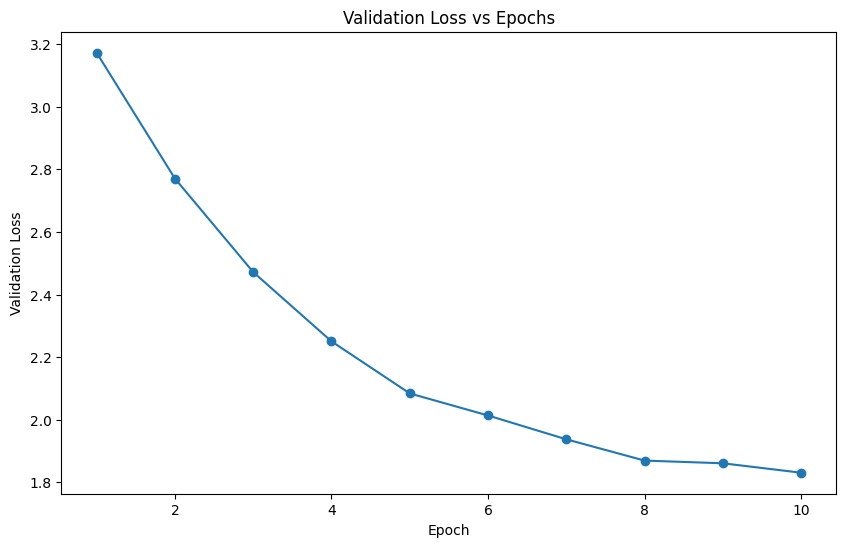

In [ ]:
history = trainer.state.log_history

# Extract validation loss data
epochs = []
val_losses = []

for entry in history:
    if 'eval_loss' in entry:
        epochs.append(entry.get('epoch'))
        val_losses.append(entry.get('eval_loss'))

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_losses, marker='o')
plt.title('Validation Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.grid(False)
plt.show()

In [ ]:
# training_args.num_train_epochs = 15
# trainer.train(resume_from_checkpoint=True)

In [ ]:
model_save_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/model/{model_name}"
trainer.save_model(model_save_path)

In [ ]:
## Trying same with BERT

In [ ]:
# empty memory
import gc


try:
    del model, trainer
except:
    pass


try:
    del optimizer
except:
    pass


for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            del obj
    except:
        pass

gc.collect()
torch.cuda.empty_cache()


print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9 - torch.cuda.memory_allocated() / 1e9:.2f} GB")

/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1113: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
<ipython-input-77-c5b771f26eb0>:19: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):


Available GPU memory: 42.47 GB


In [ ]:
model_ckpt = "bert-base-uncased"
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels) .to(device))
batch_size = 64 #CHANGE This to 64 later
logging_steps = len(train_dataset) // batch_size
model_name = f"{model_ckpt}-finetuned-author-classification"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, ## change this later
                                  log_level="error"
                                #   dataloader_pin_memory=False,     # Disable pinned memory
                                  # no_cuda=True        # Explicitly disable CUDA/GPU
)

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  tokenizer=tokenizer)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,4.020700,4.442415,0.025833,0.019199,0.018112,0.025833
2,3.274600,4.554791,0.022500,0.015559,0.014877,0.022500
3,2.897100,4.604668,0.022500,0.017666,0.016032,0.022500


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=897, training_loss=3.3956715765605403, metrics={'train_runtime': 2820.4913, 'train_samples_per_second': 10.163, 'train_steps_per_second': 0.318, 'total_flos': 7547360349634560.0, 'train_loss': 3.3956715765605403, 'epoch': 3.0})

In [ ]:
model_save_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/{model_name}"
trainer.save_model(model_save_path)

#Heirarchical approach

In [ ]:
from transformers import DefaultDataCollator

class CustomDataCollator(DefaultDataCollator):
    def __call__(self, features):
        # First create the batch with standard fields
        batch = super().__call__(features)

        # Then add custom document_id field
        if features and "document_id" in features[0]:
            batch["document_id"] = [f["document_id"] for f in features]

        return batch

In [ ]:
class DocumentTracker(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.document_ids_buffer = []

    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        print("Input keys in prediction_step:", inputs.keys())

        if "document_id" in inputs:
            print(f"Found document_id in batch, length: {len(inputs['document_id'])}")
            if isinstance(inputs["document_id"], torch.Tensor):
                doc_ids = inputs["document_id"].cpu().numpy().tolist()
            else:
                doc_ids = inputs["document_id"]

            self.document_ids_buffer.extend(doc_ids)
            print(f"Buffer now has {len(self.document_ids_buffer)} document IDs")

            # Remove document_id before passing to model
            inputs = {k: v for k, v in inputs.items() if k != "document_id"}
        else:
            print("No document_id found in batch inputs")

        return super().prediction_step(model, inputs, prediction_loss_only, ignore_keys)

    def predict(self, test_dataset, ignore_keys=None, metric_key_prefix="test"):
        self.document_ids_buffer = []
        output = super().predict(test_dataset, ignore_keys, metric_key_prefix)

        # If buffer is empty, collect document IDs directly - actually this shouldnt kick in and it doesnt !!
        if not self.document_ids_buffer:
            print("Buffer is empty, collecting document IDs directly from dataset")
            document_ids = []
            for i in range(len(test_dataset)):
                item = test_dataset[i]
                if isinstance(item, dict) and "document_id" in item:
                    document_ids.append(item["document_id"])
            self.document_ids_buffer = document_ids

        return {
            'predictions': output.predictions,
            'label_ids': output.label_ids,
            'metrics': output.metrics,
            'document_ids': self.document_ids_buffer
        }

In [ ]:
# # Define the paths
# model_ckpt = "distilbert-base-uncased"
# model_name = f"{model_ckpt}-finetuned-author-classification-updatedlabels_samples5"
# model_save_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/model/{model_name}"

# # Load the saved model
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_save_path
#     # num_labels=num_labels
# ).to(device)


In [ ]:
# Create the training arguments
training_args = TrainingArguments(
    output_dir=model_name,
    per_device_eval_batch_size=64,
    disable_tqdm=False,
    log_level="error",
    remove_unused_columns=False
)

# Create a new trainer with updated  class
trainer = DocumentTracker(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=CustomDataCollator()
)


<ipython-input-16-e120f1da83ce>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DocumentTracker.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [ ]:



results = trainer.predict(val_datasets[5])


predictions = results['predictions'] # these are raw logits
document_ids = results['document_ids']

Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 64 document IDs


Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 128 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 192 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 256 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 320 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 384 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now h

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ny-parulekar (ny-parulekar-johns-hopkins-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# covert raw logits to probabilities
pred_probab = scipy.special.softmax(predictions, axis=1)


In [ ]:
pred_probab[0].sum() # these are raw predictions , dont sum to 1.

np.float32(1.0)

In [ ]:
# for each document id weight the classprediction by the probabilies, choose final class with the highst prb

NameError: name 'shape' is not defined

In [ ]:
def get_prediction_per_document_id(document_ids, predictions, agg_type='max'):
    """
    Do predictions for each unique document ID using the specified strategy.

    agg_type: Aggregation strategy - 'max', 'prob_sum', or 'prob_product'

    Return:
    dict mapping document IDs to (predicted_class, confidence_score)
    """
    # Convert logits to probabilities
    pred_probab = scipy.special.softmax(predictions, axis=1)

    # Group samples by document ID
    doc_samples = defaultdict(list)
    for i, doc_id in enumerate(document_ids):
        doc_samples[doc_id].append(i)

    results = {}

    for doc_id, sample_indices in doc_samples.items():
        # Get probabilities for all samples of this document
        doc_probabs = pred_probab[sample_indices]

        if agg_type == 'max':
            # Find maximum probability for each class across all samples
            max_probs_per_class = np.max(doc_probabs, axis=0)
            # Get the class with the highest max probability
            predicted_class = np.argmax(max_probs_per_class)
            confidence = max_probs_per_class[predicted_class]

        elif agg_type == 'prob_sum':
            # Sum probabilities for each class across all samples
            sum_probs_per_class = np.sum(doc_probabs, axis=0)
            # Get the class with the highest summed probability
            predicted_class = np.argmax(sum_probs_per_class)
            confidence = sum_probs_per_class[predicted_class]

        elif agg_type == 'prob_product':
            # Multiply probabilities for each class across all samples
            # Add small epsilon to avoid underflow with zero probabilities. This method sucked, try log maybe
            epsilon = 1e-10
            prod_probs_per_class = np.prod(doc_probabs + epsilon, axis=0)
            # Get the class with the highest product probability
            predicted_class = np.argmax(prod_probs_per_class)
            confidence = prod_probs_per_class[predicted_class]

        else:
            raise ValueError(f"Unsupported aggregation type: {agg_type}")

        results[doc_id] = (predicted_class, confidence)

    return results


In [ ]:
get_prediction_per_document_id(document_ids, predictions, agg_type='max')

In [ ]:
def evaluate_document_aggregation_strategies(predictions, document_ids, dataset):
    """
     different aggregation strategies for document-level predictions.

    """
    # Extract true labels from dataset
    true_labels = [dataset[i]["labels"].item() for i in range(len(dataset))]

    # Aggregate true labels by document ID using majority vote
    doc_label_counts = defaultdict(lambda: defaultdict(int))

    for i, doc_id in enumerate(document_ids):
        doc_label_counts[doc_id][true_labels[i]] += 1

    true_doc_labels = {}
    for doc_id, label_counts in doc_label_counts.items():
        # Find the most common label for this document (majority vote)
        true_doc_labels[doc_id] = max(label_counts.items(), key=lambda x: x[1])[0]

    # Apply different aggregation strategies
    strategies = ['max', 'prob_sum', 'prob_product']
    results = {}
    metrics = {}

    for strategy in strategies:
        # Get document-level predictions using the aggregation strategy
        doc_predictions = get_prediction_per_document_id(document_ids, predictions, strategy)

        # Prepare arrays for metrics calculation
        doc_ids_ordered = list(doc_predictions.keys())
        y_true = [true_doc_labels[doc_id] for doc_id in doc_ids_ordered]
        y_pred = [doc_predictions[doc_id][0] for doc_id in doc_ids_ordered]

        # Calculate metrics
        f1 = f1_score(y_true, y_pred, average="weighted")
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average="weighted")
        recall = recall_score(y_true, y_pred, average="weighted")

        metrics[strategy] = {
            "accuracy": acc,
            "f1": f1,
            "precision": precision,
            "recall": recall
        }

        results[strategy] = doc_predictions


    print("\nMetrics by aggregation strategy:")
    for strategy, metric_dict in metrics.items():
        print(f"\n{strategy.upper()}:")
        for metric_name, metric_value in metric_dict.items():
            print(f"  {metric_name}: {metric_value:.4f}")

    return metrics, results

In [ ]:
# Evaluate the different aggregation strategies
metrics, prediction_results = evaluate_document_aggregation_strategies(
    predictions,
    document_ids,
    val_datasets[5]
)




Metrics by aggregation strategy:

MAX:
  accuracy: 0.6917
  f1: 0.6767
  precision: 0.7289
  recall: 0.6917

PROB_SUM:
  accuracy: 0.6917
  f1: 0.6860
  precision: 0.7482
  recall: 0.6917

PROB_PRODUCT:
  accuracy: 0.7000
  f1: 0.6990
  precision: 0.7594
  recall: 0.7000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
metrics

{'max': {'accuracy': 0.6916666666666667,
  'f1': 0.6767460317460318,
  'precision': 0.7288988095238095,
  'recall': 0.6916666666666667},
 'prob_sum': {'accuracy': 0.6916666666666667,
  'f1': 0.6860119047619048,
  'precision': 0.748154761904762,
  'recall': 0.6916666666666667},
 'prob_product': {'accuracy': 0.7,
  'f1': 0.6989781746031746,
  'precision': 0.7593912337662337,
  'recall': 0.7}}

# first hyperparam tuning with Optuna and then heirarchical prediction

In [ ]:
# def clear_memory():
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()
#     gc.collect()

In [ ]:
def clear_memory():
    """Free up GPU memory by emptying cache and garbage collection"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

In [ ]:
# Optuna using existing Trainer


def objective(trial,num_train_epochs,chunk_idx,train_datasets,val_datasets,label_to_id_train,tokenizer):
    # Define the hyperparameters to optimize
    gdrive_path = "/content/drive/MyDrive/TheoryofML_GroupProject/model/distill-bert-optuna"
    hparams = {
        "learning_rate": trial.suggest_float("learning_rate", 5e-6, 5e-4, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.001, 0.1, log=True),
        "dropout": trial.suggest_float("dropout", 0.1, 0.5),
        "attention_dropout": trial.suggest_float("attention_dropout", 0.1, 0.5),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    }

    # Create a model with the trial hyperparameters

    model_ckpt = "distilbert-base-uncased"
    model = AutoModelForSequenceClassification.from_pretrained(
            model_ckpt,
            num_labels=len(label_to_id_train),
            dropout=hparams["dropout"],
        attention_dropout=hparams["attention_dropout"]
        ).to(device)


    # batch_size = 64
    # logging_steps = len(train_datasets[30]) // batch_size
    model_name = f"{model_ckpt}-finetuned-author-classification-hyp_samples30"

    trial_output_dir = os.path.join(gdrive_path, f"{model_name}-trial-{trial.number}")
    os.makedirs(trial_output_dir, exist_ok=True)

    # Set up training arguments with trial hyperparameters
    training_args = TrainingArguments(
        output_dir=trial_output_dir,
        num_train_epochs=num_train_epochs,
        learning_rate=hparams["learning_rate"],
        per_device_train_batch_size=hparams["batch_size"],
        per_device_eval_batch_size=hparams["batch_size"],
        weight_decay=hparams["weight_decay"],
        eval_strategy="epoch",
        disable_tqdm=False,
        # logging_steps=logging_steps,
        push_to_hub=False,
        log_level="error",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False  # We want to minimize validation loss
    )

    # Set up trainer for this trial
    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_datasets[chunk_idx],
        eval_dataset=val_datasets[chunk_idx],
        tokenizer=tokenizer
    )

    try:
        # Train the model with error handling
        trainer.train()
    except RuntimeError as e:
        if 'CUDA out of memory' in str(e):
            print(f"Pruned trial {trial.number} due to OOM error with batch size {hparams['batch_size']}")
            # Cleanup before pruning
            del model, trainer
            clear_memory()
            # Mark trial as pruned
            raise optuna.exceptions.TrialPruned()
        # Re-raise other errors
        raise


    trial_results_path = os.path.join(trial_output_dir, "results.txt")

    # Evaluate the model and return the validation loss
    eval_result = trainer.evaluate()
    loss_value = eval_result["eval_loss"]

    # Cleanup after successful trial
    del model, trainer
    clear_memory()

    return loss_value




[I 2025-04-25 16:35:45,269] A new study created in memory with name: no-name-f565d572-9bc5-47d5-b0cd-8bb12f178c0a


In [ ]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
study_name = "optuna_study.pkl"
gdrive_study_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/{study_name}"


In [ ]:
def save_callback(study, frozen_trial):
    joblib.dump(study, gdrive_study_path)


In [ ]:

pruner = MedianPruner(n_startup_trials=1, n_warmup_steps=5)
study = optuna.create_study(direction="minimize", pruner=pruner)


study.optimize(functools.partial(objective, num_train_epochs=8,
                                 chunk_idx=30,
                                 train_datasets=train_datasets,
                                 val_datasets=val_datasets,
                                 label_to_id_train=label_to_id_train,
                                 tokenizer = tokenizer), n_trials=5,callbacks=[save_callback])


print("Best trial:")
trial = study.best_trial
print(f"  Value (Validation Loss): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,4.382400,4.382067,0.012500,0.000309,0.000156,0.012500
2,4.384500,4.382065,0.012500,0.000309,0.000156,0.012500
3,4.382400,4.382031,0.012500,0.000309,0.000156,0.012500
4,4.382300,4.382030,0.012500,0.000309,0.000156,0.012500
5,4.382200,4.382029,0.012500,0.000309,0.000156,0.012500
6,4.382200,4.382029,0.012500,0.000309,0.000156,0.012500
7,4.382100,4.382028,0.012500,0.000309,0.000156,0.012500
8,4.382100,4.382028,0.012500,0.000309,0.000156,0.012500


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-25 22:52:17,687] Trial 4 finished with value: 4.382028102874756 and parameters: {'learning_rate': 0.00039714327829420395, 'weight_decay': 0.003256697669057124, 'dropout': 0.14139197324866398, 'attention_dropout': 0.3197560584046142, 'batch_size': 32}. Best is trial 3 with value: 4.154952526092529.


Pruned trial 5 due to OOM error with batch size 128


[I 2025-04-25 22:52:20,674] Trial 5 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.813400,1.676478,0.562778,0.564317,0.623671,0.562778
2,0.524800,1.563261,0.619444,0.617077,0.651058,0.619444
3,0.194800,1.722435,0.636944,0.632753,0.664717,0.636944
4,0.094600,1.725137,0.660139,0.655859,0.694118,0.660139
5,0.049200,1.935014,0.658056,0.653680,0.685551,0.658056
6,0.027000,1.849917,0.683333,0.682053,0.707825,0.683333
7,0.013600,1.933449,0.676944,0.674677,0.703216,0.676944
8,0.008500,1.896831,0.685278,0.681593,0.702965,0.685278


[I 2025-04-26 05:12:36,366] Trial 6 finished with value: 1.563260555267334 and parameters: {'learning_rate': 7.197256988165609e-05, 'weight_decay': 0.0860163714518151, 'dropout': 0.30000377568834935, 'attention_dropout': 0.1996514307843317, 'batch_size': 64}. Best is trial 6 with value: 1.563260555267334.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,4.217400,3.696571,0.059028,0.020757,0.015463,0.059028


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# GAH disconnected in epoch 1 of trial 7 (3 already done but not counted and 5 more so was supposed ot be tll 8 )



In [ ]:
# load best model thusfar

In [ ]:
# 1. Load the saved study
study_name = "optuna_study.pkl"
gdrive_study_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/{study_name}"

# Load the study object
study = joblib.load(gdrive_study_path)

# 2. Get the best trial number
best_trial_number = study.best_trial.number
print(f"Best trial number: {best_trial_number}")
print(f"Best validation loss: {study.best_value}")
print("Best hyperparameters:")
for param_name, param_value in study.best_params.items():
    print(f"  {param_name}: {param_value}")

#

Best trial number: 6
Best validation loss: 1.563260555267334
Best hyperparameters:
  learning_rate: 7.197256988165609e-05
  weight_decay: 0.0860163714518151
  dropout: 0.30000377568834935
  attention_dropout: 0.1996514307843317
  batch_size: 64


In [ ]:
#load best model
gdrive_path = "/content/drive/MyDrive/TheoryofML_GroupProject/model/distill-bert-optuna"
model_ckpt = "distilbert-base-uncased"
model_name = f"{model_ckpt}-finetuned-author-classification-hyp_samples30"
best_model_dir = f"{gdrive_path}/{model_name}-trial-{best_trial_number}"



checkpoints = [d for d in os.listdir(best_model_dir) if d.startswith("checkpoint-")]
if checkpoints:
    # Sort checkpoints to find the latest one
    checkpoints.sort(key=lambda x: int(x.split("-")[1]))
    best_checkpoint = os.path.join(best_model_dir, checkpoints[-1])
    print(f"Loading best model from: {best_checkpoint}")



Loading best model from: /content/drive/MyDrive/TheoryofML_GroupProject/model/distill-bert-optuna/distilbert-base-uncased-finetuned-author-classification-hyp_samples30-trial-6/checkpoint-7200


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(best_checkpoint)
num_labels = len(label_to_id_val)
model = AutoModelForSequenceClassification.from_pretrained(
    best_checkpoint,
    num_labels=num_labels
).to(device)


In [ ]:
# do model_to_device
# get heirarchical predictions on validation set

In [ ]:
training_args = TrainingArguments(
output_dir="/content/drive/MyDrive/TheoryofML_GroupProject/model/distill-bert-optuna/best_heir_eval_ext",
per_device_eval_batch_size=64,
disable_tqdm=False,
log_level="error",
remove_unused_columns=False
)

trainer = DocumentTracker( #defined before in the heir section
model=model,
args=training_args,
compute_metrics=compute_metrics,
tokenizer=tokenizer,
data_collator=CustomDataCollator() #defined before in the heir section

)

In [ ]:
results = trainer.predict(val_datasets[30])

Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 64 document IDs


Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 128 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 192 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 256 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 320 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 384 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now h

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ny-parulekar (ny-parulekar-johns-hopkins-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# predictions = results['predictions'] # these are raw logits

# document_ids = results['document_ids']


In [ ]:
predictions = results['predictions'] # these are raw logits

document_ids = results['document_ids']


metrics, prediction_results = evaluate_document_aggregation_strategies(
predictions,
document_ids,
val_datasets[30]
)


Metrics by aggregation strategy:

MAX:
  accuracy: 0.8250
  f1: 0.8127
  precision: 0.8424
  recall: 0.8250

PROB_SUM:
  accuracy: 0.8625
  f1: 0.8522
  precision: 0.8829
  recall: 0.8625

PROB_PRODUCT:
  accuracy: 0.8000
  f1: 0.8275
  precision: 0.9135
  recall: 0.8000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
results = trainer.predict(val_datasets_ext[2000])
predictions = results['predictions'] # these are raw logits

document_ids = results['document_ids']



Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 64 document IDs


Streaming output truncated to the last 5000 lines.
Found document_id in batch, length: 64
Buffer now has 373376 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 373440 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 373504 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 373568 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 373632 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 373696 document IDs
Input keys

NameError: name 'val_datasets' is not defined

In [ ]:

metrics, prediction_results = evaluate_document_aggregation_strategies(
predictions,
document_ids,
val_datasets_ext[2000]
)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Metrics by aggregation strategy:

MAX:
  accuracy: 0.8333
  f1: 0.8230
  precision: 0.8640
  recall: 0.8333

PROB_SUM:
  accuracy: 0.8833
  f1: 0.8786
  precision: 0.9137
  recall: 0.8833

PROB_PRODUCT:
  accuracy: 0.1000
  f1: 0.1128
  precision: 0.1752
  recall: 0.1000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
metric_path = "/content/drive/MyDrive/TheoryofML_GroupProject/results/distill-bert/metrics-val-2000.pkl"
result_path =  "/content/drive/MyDrive/TheoryofML_GroupProject/results/distill-bert/prediction_results-val-2000.pkl"

save_pkl_to_drive(metrics, metric_path)
save_pkl_to_drive(prediction_results, result_path)

In [ ]:
results = trainer.predict(test_datasets[2000])
predictions = results['predictions'] # these are raw logits

document_ids = results['document_ids']



Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 64 document IDs


Streaming output truncated to the last 5000 lines.
Found document_id in batch, length: 64
Buffer now has 373376 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 373440 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 373504 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 373568 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 373632 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'document_id'])
Found document_id in batch, length: 64
Buffer now has 373696 document IDs
Input keys

In [ ]:
metrics, prediction_results = evaluate_document_aggregation_strategies(
predictions,
document_ids,
test_datasets[2000]
)


Metrics by aggregation strategy:

MAX:
  accuracy: 0.7917
  f1: 0.7843
  precision: 0.8545
  recall: 0.7917

PROB_SUM:
  accuracy: 0.8875
  f1: 0.8842
  precision: 0.9181
  recall: 0.8875

PROB_PRODUCT:
  accuracy: 0.1000
  f1: 0.1153
  precision: 0.1877
  recall: 0.1000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
metric_path = "/content/drive/MyDrive/TheoryofML_GroupProject/results/distill-bert/metrics-test-2000.pkl"
result_path =  "/content/drive/MyDrive/TheoryofML_GroupProject/results/distill-bert/prediction_results-test-2000.pkl"

save_pkl_to_drive(metrics, metric_path)
save_pkl_to_drive(prediction_results, result_path)

In [ ]:
metrics

# Analysis

In [ ]:
# model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define the paths
model_ckpt = "distilbert-base-uncased"
model_name = f"{model_ckpt}-finetuned-author-classification-updatedlabels_samples5"
model_save_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/model/{model_name}"

# Load the saved model
model = AutoModelForSequenceClassification.from_pretrained(
    model_save_path
    # num_labels=num_labels
).to(device)


In [ ]:
def load_pkl_from_drive(drive_path):

    with open(drive_path, 'rb') as f:
        return pickle.load(f)


# train_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/pytorch_dataset/train_datasets.pkl"
# val_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/pytorch_dataset/val_datasets.pkl"


# train_datasets = load_pkl_from_drive(train_path)
# val_datasets = load_pkl_from_drive(val_path)

# get  specific datasets using the keys, e.g.:
# sample_5_dataset = train_datasets[5]

In [ ]:


train_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/pytorch_dataset/train_datasets.pkl"
val_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/pytorch_dataset/val_datasets.pkl"


train_datasets = load_pkl_from_drive(train_path)
val_datasets = load_pkl_from_drive(val_path)


In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [ ]:
# num_labels = train_meta_df['author'].nunique()
# # model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels) .to(device))

In [ ]:
#  existing TrainingArguments and Trainer setup
batch_size = 64
logging_steps = len(train_datasets[5]) // batch_size
model_name = f"{model_ckpt}-finetuned-author-classification-updatedlabels_samples5"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error"
)

# Create the Trainer with loaded model
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_datasets[5],
                  eval_dataset=val_datasets[5],
                  tokenizer=tokenizer)


<ipython-input-30-38a4f1fe7d40>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


In [ ]:
preds_output = trainer.predict(val_datasets[5])  # or val_datasets[5] if you're using the original datasets

# Access predictions
predictions = preds_output.predictions
labels = preds_output.label_ids
metrics = preds_output.metrics

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ny-parulekar (ny-parulekar-johns-hopkins-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [ ]:
#label_to_id_train

In [ ]:
# def plot_confusion_matrix(y_preds, y_true, labels,label_to_id_train):
#   # Get the 80 unique classes
#     unique_classes = sorted(np.unique(np.concatenate([y_true, y_preds])))
#     class_names = label_to_id_train # get the key for the value using this dict
#     cm = confusion_matrix(y_true, y_preds, normalize="true")
#     fig, ax = plt.subplots(figsize=(6, 6))
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
#     disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
#     plt.title("Normalized confusion matrix")
#     plt.show()

In [ ]:
def plot_confusion_matrix(y_preds, y_true, label_to_id_dict):

    id_to_label = {id_num: author for author, id_num in label_to_id_dict.items()}
    unique_classes = sorted(np.unique(np.concatenate([y_true, y_preds])))
    author_names = [id_to_label[class_id] for class_id in unique_classes]
    cm = confusion_matrix(y_true, y_preds, labels=unique_classes, normalize="true")

    fig_size = min(20, max(12, len(unique_classes)/4))
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=author_names)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False, xticks_rotation=90)

    plt.title("Normalized confusion matrix")
    plt.tight_layout()
    plt.show()

    return disp  # Re

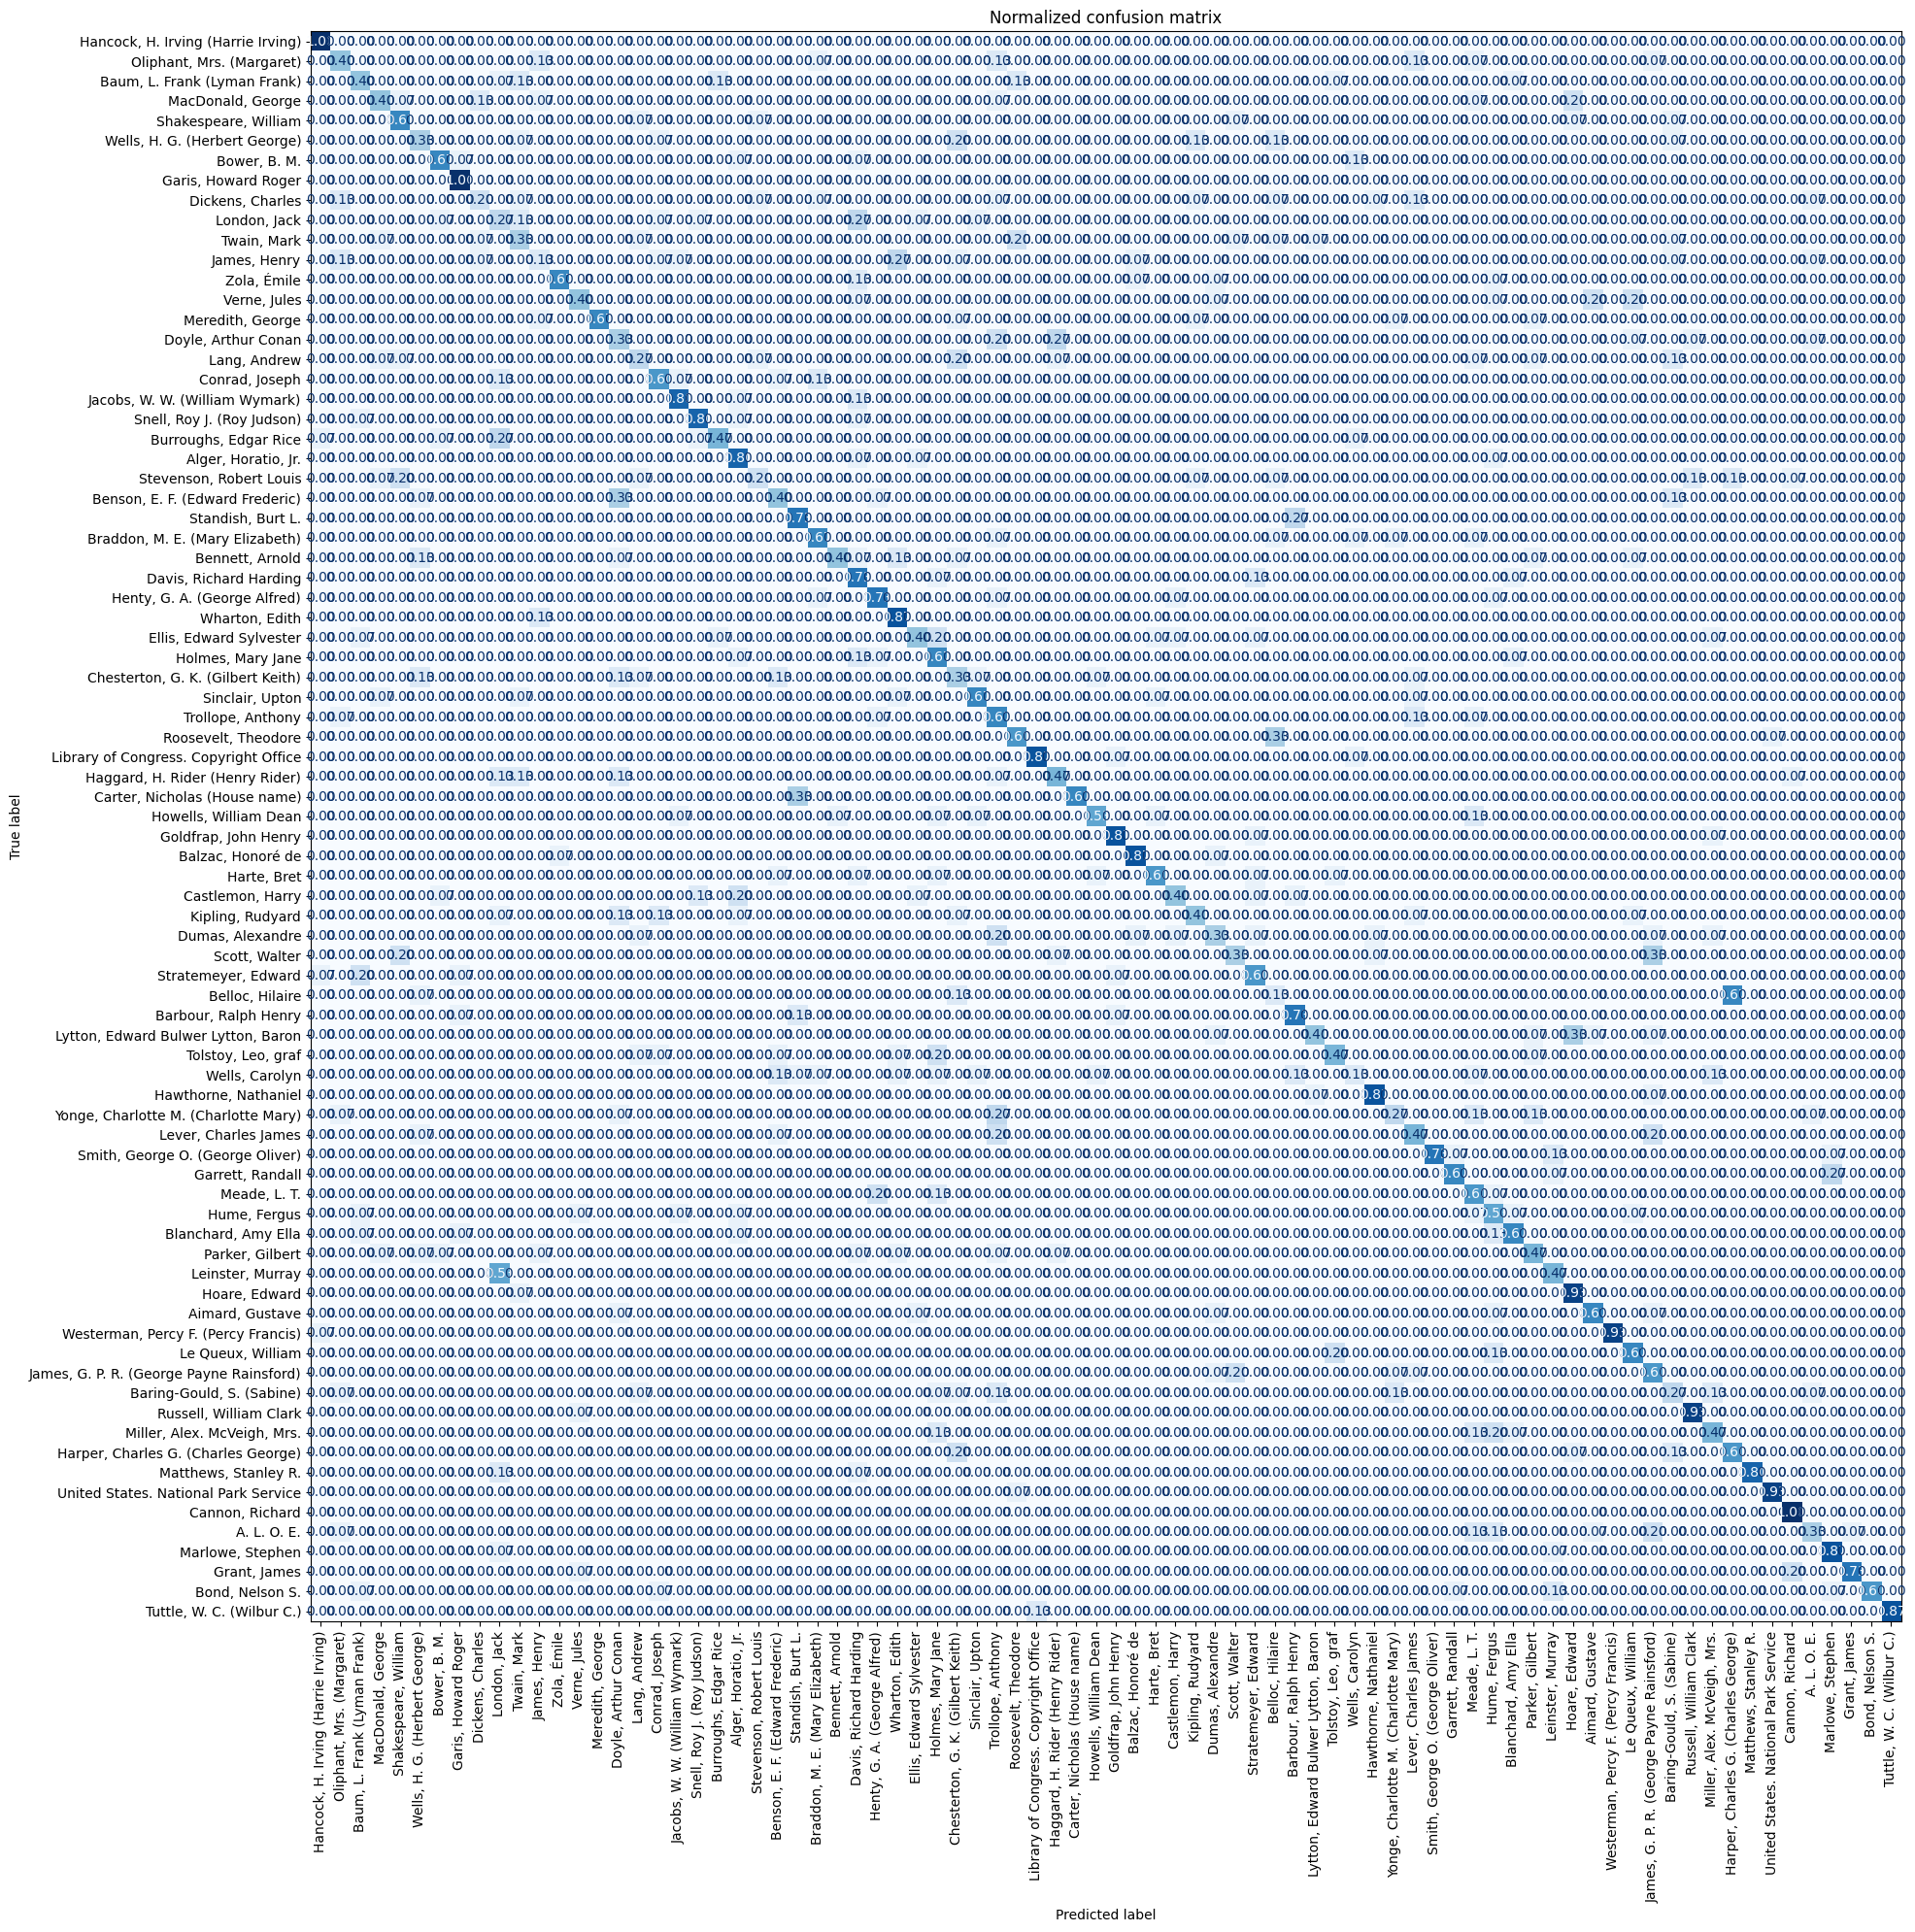

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1) # greedy prediction y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids


plot_confusion_matrix(y_preds, y_true, label_to_id_train)

In [ ]:
from torch.nn.functional import cross_entropy
from torch.utils.data import DataLoader
import pandas as pd
import torch

In [ ]:
def forward_pass_with_label(model, dataset, batch_size=16):

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    results = []
    model.eval()

    with torch.no_grad():
        for batch in dataloader:

            inputs = {
                k: v.to(device) for k, v in batch.items()
                if k in ['input_ids', 'attention_mask']
            }
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(**inputs)
            logits = outputs.logits

            # Get predictions and loss
            predicted_labels = torch.argmax(logits, dim=1)
            losses = cross_entropy(logits, labels, reduction="none")

            # Store results for each sample in the batch
            for i in range(len(labels)):
                # Get the text by decoding the input_ids
                text = tokenizer.decode(batch['input_ids'][i], skip_special_tokens=True)

                # Add document_id if available
                doc_id = None
                if 'document_id' in batch:
                    doc_id = batch['document_id'][i].item() if isinstance(batch['document_id'][i], torch.Tensor) else batch['document_id'][i]

                results.append({
                    'text': text,
                    'true_label': labels[i].item(),
                    'predicted_label': predicted_labels[i].item(),
                    'loss': losses[i].item(),
                    'document_id': doc_id
                })

    return results


In [ ]:
val_meta_df.head()

,Unnamed: 0.1,Unnamed: 0,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects
0,0,403,PG10567,"The Guardian Angel: Ship's Company, Part 7.","Jacobs, W. W. (William Wymark)",1863.0,1943.0,['en'],94,"{'Humorous stories, English', 'England -- Soci..."
1,9,1247,PG11476,"Husbandry: Deep Waters, Part 6.","Jacobs, W. W. (William Wymark)",1863.0,1943.0,['en'],129,"{'Humorous stories, English', 'Sailors -- Fict..."
2,74,10009,PG21927,Short Cruises,"Jacobs, W. W. (William Wymark)",1863.0,1943.0,['en'],218,"{'River life -- Fiction', 'Humorous stories, E..."
3,73,9704,PG215,The call of the wild,"London, Jack",1876.0,1916.0,['en'],6642,"{'Dogs -- Fiction', 'Sled dogs -- Fiction', 'F..."
4,1,406,PG1056,Martin Eden,"London, Jack",1876.0,1916.0,['en'],2658,"{'Working class -- Fiction', 'Authors -- Ficti..."


In [ ]:

# Create a reverse mapping from IDs to author names
id_to_author = {id_num: author for author, id_num in label_to_id_train.items()}

# Function to convert label ID to author name
def label_id_to_author(label_id):
    return id_to_author.get(label_id, f"Unknown_{label_id}")

# Run forward pass specifically on the validation dataset with key 5
results = forward_pass_with_label(model, val_datasets[5])


                                                text  true_label  \
0  looked at each other, but they was so hungry t...          18   
1  ' e was paying for ' em, and it was all pore g...          18   
2  for over a week, and he ' ad so much praise fr...          18   
3  ' you got your money back. wot ' s the good o ...          18   
4  ; and ' arf of fourpence is twopence. ' " ' wh...          18   

   predicted_label      loss document_id                     true_author  \
0               18  0.172263     PG10567  Jacobs, W. W. (William Wymark)   
1               18  0.293404     PG10567  Jacobs, W. W. (William Wymark)   
2               18  0.224748     PG10567  Jacobs, W. W. (William Wymark)   
3               18  0.208486     PG10567  Jacobs, W. W. (William Wymark)   
4               18  0.226133     PG10567  Jacobs, W. W. (William Wymark)   

                 predicted_author  
0  Jacobs, W. W. (William Wymark)  
1  Jacobs, W. W. (William Wymark)  
2  Jacobs, W. W. (William 

In [ ]:

# Create a DataFrame with the results
df_loss = pd.DataFrame(results)

# Convert numerical labels to author names
df_loss['true_author'] = df_loss['true_label'].apply(label_id_to_author)
df_loss['predicted_author'] = df_loss['predicted_label'].apply(label_id_to_author)

# using val_meta_df join on id to document_id in df_loss and pull columns title and subjects
df_loss = df_loss.merge(
    val_meta_df[['id', 'title', 'subjects']],
    left_on='document_id',
    right_on='id',
    how='left'
)


accuracy = (df_loss['true_label'] == df_loss['predicted_label']).mean()


In [ ]:
accuracy

np.float64(0.58)

In [ ]:

pd.set_option('display.max_colwidth', 100)


In [ ]:
df_high_loss = df_loss.sort_values('loss', ascending=False).head(10)
df_high_loss

,text,true_label,predicted_label,loss,document_id,true_author,predicted_author,id,title,subjects
242,satisfaction. the parts are taken by six male and six female characters. = phunny phellow ' s gr...,45,47,6.978679,PG42757,"Dumas, Alexandre","Stratemeyer, Edward",PG42757,"The Countess of Charny; or, The Execution of King Louis XVI","{'France -- History -- Revolution, 1789-1799 -- Fiction', 'Marie Antoinette, Queen, consort of L..."
176,"as a whole, the government, after a careful consideration of the question, came to the conclusio...",37,74,6.958018,PG44649,"Haggard, H. Rider (Henry Rider)","Cannon, Richard",PG44649,The Last Boer War,{'Transvaal (South Africa) -- History -- War of 1880-1881'}
894,"day. "" - - _ chicago times. _ "" remarkably powerful, and is undoubtedly one of the strongest wor...",68,70,6.864821,PG44455,"Baring-Gould, S. (Sabine)","Miller, Alex. McVeigh, Mrs.",PG44455,Noémi,"{'France -- History -- 15th century -- Fiction', 'Brigands and robbers -- Fiction', 'Historical ..."
814,a long trial — only a year. even a profligate might keep faith for so short a span. ” “ i see yo...,25,52,6.605201,PG75410,"Braddon, M. E. (Mary Elizabeth)","Wells, Carolyn",PG75410,"The fatal three, vol. I","{'England -- Social life and customs -- 19th century -- Fiction', 'Guardian and ward -- Fiction'..."
40,"into the lid, dragging it along as far as i could in a straight line and working it so as to mak...",12,27,6.550622,PG1069,"Zola, Émile","Davis, Richard Harding",PG1069,Four Short Stories By Emile Zola,"{'France -- Social life and customs -- Fiction', 'Short stories'}"
893,"$ 16. 50. also, 12mo edition of the above ( except "" a question, "" "" the elixir, "" "" cleopatra, ...",68,70,6.516070,PG44455,"Baring-Gould, S. (Sabine)","Miller, Alex. McVeigh, Mrs.",PG44455,Noémi,"{'France -- History -- 15th century -- Fiction', 'Brigands and robbers -- Fiction', 'Historical ..."
175,"whilst talking to them was shot dead. the rev. j. thorne, the english clergyman at lydenburg, de...",37,34,6.477099,PG44649,"Haggard, H. Rider (Henry Rider)","Trollope, Anthony",PG44649,The Last Boer War,{'Transvaal (South Africa) -- History -- War of 1880-1881'}
480,"a sacrifice to his cruel persecutor, who, delighting her eyes with the spectacle, still waiting ...",10,50,6.284496,PG61522,"Twain, Mark","Lytton, Edward Bulwer Lytton, Baron",PG61522,"The £1,000,000 bank-note, and other new stories","{'Humorous stories, American', 'American essays -- 19th century', 'American fiction -- 19th cent..."
898,her hands contracted on what she held ; she could not have let them fall had she willed to relax...,68,31,6.066966,PG48161,"Baring-Gould, S. (Sabine)","Holmes, Mary Jane",PG48161,"The Pennycomequicks, Volume 1 (of 3)","{'England -- Social life and customs -- 19th century -- Fiction', 'Missing persons -- Fiction', ..."
177,"p. s. "" ) in a very different work, "" a farmer ' s year, "" pages 179 and 380, i have attempted t...",37,10,6.040145,PG44649,"Haggard, H. Rider (Henry Rider)","Twain, Mark",PG44649,The Last Boer War,{'Transvaal (South Africa) -- History -- War of 1880-1881'}


In [ ]:
df_low_loss = df_test.sort_values('loss', ascending=True).head(30)
df_low_loss


,text,true_label,predicted_label,loss,document_id,true_author,predicted_author
161,"##b ) ; 18dec67 ; r424221. wunderlich, frieda....",36,36,0.072735,PG11836,Library of Congress. Copyright Office,Library of Congress. Copyright Office
999,"dependencies, which he held until june, 1815, ...",74,74,0.073268,PG52793,"Cannon, Richard","Cannon, Richard"
160,##8430. 30. © 20aug40 ; a144376. 28sep67 ; r41...,36,36,0.073405,PG11836,Library of Congress. Copyright Office,Library of Congress. Copyright Office
162,"r418658. no scandal. ( in redbook, june 1940 )...",36,36,0.073868,PG11836,Library of Congress. Copyright Office,Library of Congress. Copyright Office
156,##47 ; a18379. frederick emmons terman ( a ) ;...,36,36,0.074463,PG11851,Library of Congress. Copyright Office,Library of Congress. Copyright Office
996,"foot - guards, in which corps he was appointed...",74,74,0.074952,PG52793,"Cannon, Richard","Cannon, Richard"
164,"##dlerowa, zoe. my name is million. © 5sep40, ...",36,36,0.075598,PG11836,Library of Congress. Copyright Office,Library of Congress. Copyright Office
155,##ug47 ; a14777. mary maurine lair ( w ) ; 13j...,36,36,0.075645,PG11851,Library of Congress. Copyright Office,Library of Congress. Copyright Office
159,"publications, inc. ( pwh ) ; 20jun75 ; r608076...",36,36,0.077124,PG11851,Library of Congress. Copyright Office,Library of Congress. Copyright Office
163,joseph warren. rosanna of the amish. illustrat...,36,36,0.077168,PG11836,Library of Congress. Copyright Office,Library of Congress. Copyright Office


In [ ]:
# just show confusion matrix for authors with high loss
  # take the avg loss per class (column true_author ) and show the top 10 authors
df_avg_loss = df_loss.groupby('true_author')['loss'].mean().reset_index()
df_avg_loss = df_avg_loss.sort_values('loss', ascending=False).head(10)


In [ ]:
df_avg_loss

,true_author,loss
5,"Baring-Gould, S. (Sabine)",3.550207
29,"Haggard, H. Rider (Henry Rider)",3.399558
41,"James, Henry",3.269073
23,"Dumas, Alexandre",3.224136
7,"Belloc, Hilaire",3.142969
78,"Yonge, Charlotte M. (Charlotte Mary)",2.954625
6,"Baum, L. Frank (Lyman Frank)",2.856375
71,"Twain, Mark",2.841112
43,"Lang, Andrew",2.785859
66,"Stevenson, Robert Louis",2.782429


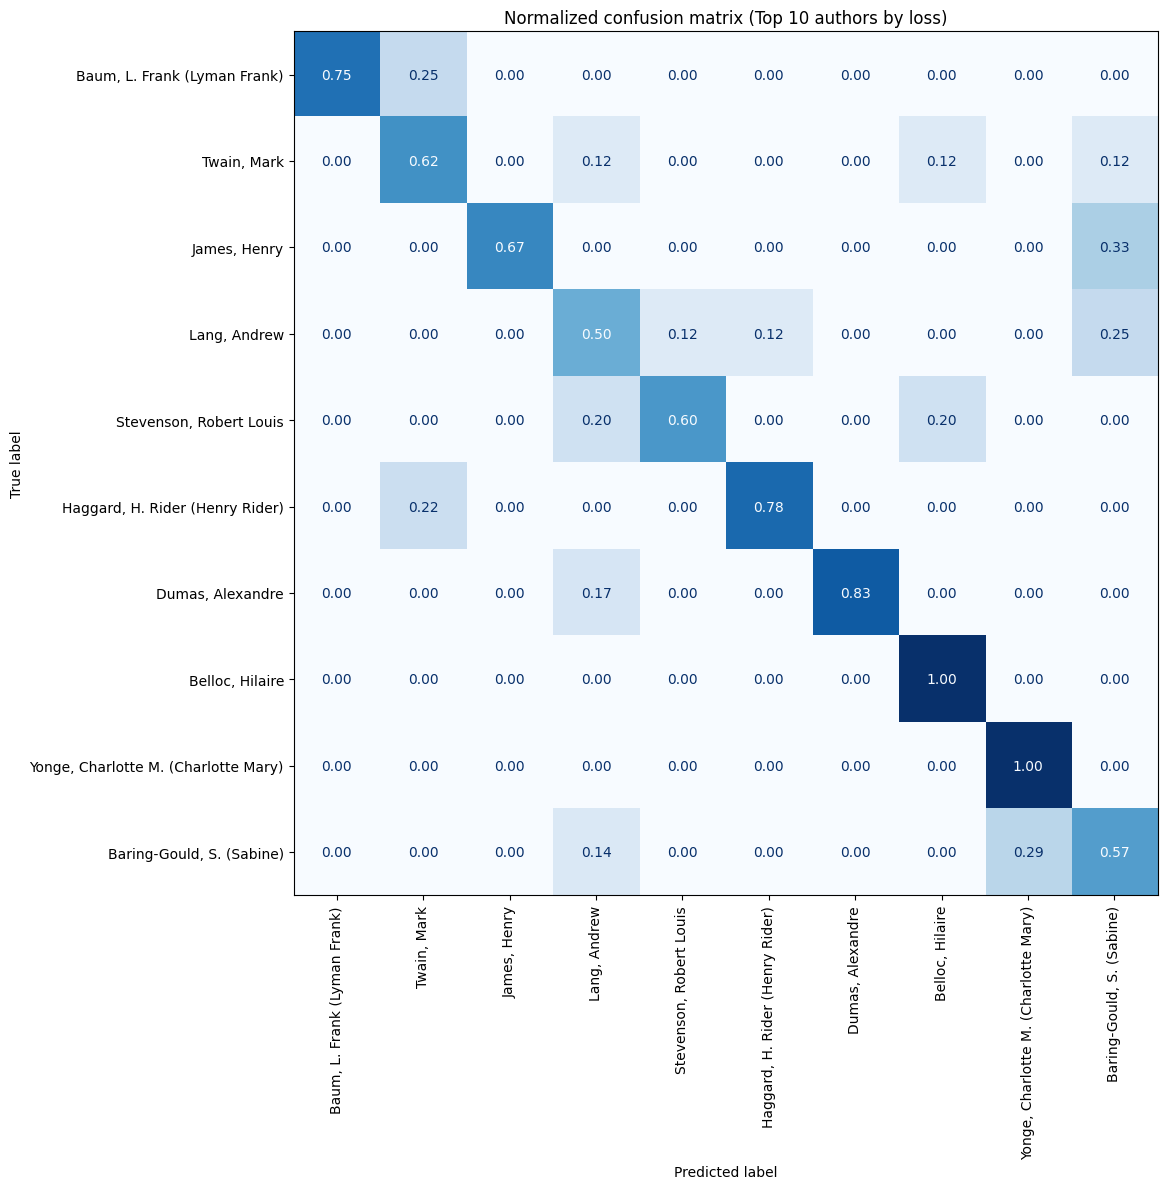

In [ ]:
# Get the list of top authors from df_avg_loss
top_authors = df_avg_loss['true_author'].tolist()

top_author_ids = [label_to_id_train[author] for author in top_authors]

mask = np.isin(y_true, top_author_ids)
filtered_y_true = y_true[mask]
filtered_y_preds = y_preds[mask]


id_to_label = {id_num: author for author, id_num in label_to_id_train.items()}


def plot_filtered_confusion_matrix(y_preds, y_true, label_to_id_dict, top_author_ids):

    id_to_label = {id_num: author for author, id_num in label_to_id_dict.items()}
    unique_classes = sorted(np.unique(np.concatenate([y_true, y_preds])))
    unique_classes = [cls for cls in unique_classes if cls in top_author_ids]
    author_names = [id_to_label[class_id] for class_id in unique_classes]

    cm = confusion_matrix(y_true, y_preds, labels=unique_classes, normalize="true")


    fig_size = min(20, max(12, len(unique_classes)/4))
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))


    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=author_names)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False, xticks_rotation=90)

    plt.title("Normalized confusion matrix (Top 10 authors by loss)")
    plt.tight_layout()
    plt.show()

    return disp


plot_filtered_confusion_matrix(filtered_y_preds, filtered_y_true, label_to_id_train, top_author_ids)

# Long form text transformer (sparse attention)


In [ ]:
# Change model checkpoint and import
# from transformers import LongformerForSequenceClassification, AutoTokenizer
model_ckpt = "allenai/longformer-base-4096"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Update max length for Longformer
max_length = 4096  # Longformer can handle much longer sequences

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:

num_samples_list_long = [1,3,4,5,6]

results_train_long, label_to_id_train_long = get_token_samples_multiple(path_gutenberg,
                                                                        num_samples_list_long,
                                                                        train_meta_df,
                                                                        tokenizer,
                                                                        max_length,
                                                                        use_global_attention=True,
                                                                        strip_tokens=100)

# results_train_long, label_to_id_train_long = get_token_samples_multiple_global(
#     path_gutenberg,
#     num_samples_list_long,
#     train_meta_df,
#     tokenizer,
#     max_length
# )

results_val_long, label_to_id_val_long = get_token_samples_multiple(
    path_gutenberg,
    num_samples_list_long,
    val_meta_df,
    tokenizer,
    max_length,
    existing_label_to_id=label_to_id_train_long,
    use_global_attention=True,
    strip_tokens=100
)




In [ ]:
train_meta_df.loc[train_meta_df['id'] =='PG75760' ]

,Unnamed: 0,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects
1592,54835,PG75760,The house of evil,"Le Queux, William",1864.0,1927.0,['en'],0,set()


In [ ]:
num_samples_list_long = [1,3,4,5,6,7,8,9,10,15,20,25,30,40,45,50,55,60]
results_test_long, label_to_id_test_long = get_token_samples_multiple(
    path_gutenberg,
    num_samples_list_long,
    test_meta_df,
    tokenizer,
    max_length,
    existing_label_to_id=label_to_id_train_long,
    use_global_attention=True,
    strip_tokens=100
)


In [ ]:
label_to_id_train_long == label_to_id_test_long

True

In [ ]:

train_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/train_tokenized_long.pkl"
val_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/val_tokenized_long.pkl"
test_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/test_tokenized_long.pkl"
label_to_id_train_long_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/label_to_id_train_long.pkl"


# save_pkl_to_drive(results_train_long, train_path)
# save_pkl_to_drive(results_val_long, val_path)

# save_pkl_to_drive(results_test_long, test_path)
# save_pkl_to_drive(label_to_id_train_long, label_to_id_train_long_path)

In [ ]:
label_to_id_train_long = load_pkl_from_drive(label_to_id_train_long_path)

In [ ]:
train_datasets_long = create_datasets_from_results(
    results_train_long,
    use_global_attention=True,
)
val_datasets_long = create_datasets_from_results(
    results_val_long,
    use_global_attention=True,  # Enable global attention for Longformer
)


In [ ]:
test_datasets_long = create_datasets_from_results(
    results_test_long,
    use_global_attention=True,
)

In [ ]:
# save to pkl

train_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/pytorch_dataset/train_datasets_long.pkl"
val_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/pytorch_dataset/val_datasets_long.pkl"
test_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/pytorch_dataset/test_datasets_long.pkl"


# save_pkl_to_drive(test_datasets_long, test_path)
# save_pkl_to_drive(train_datasets_long, train_path)
# save_pkl_to_drive(val_datasets_long, val_path)

In [ ]:
train_datasets_long = load_pkl_from_drive(train_path)
val_datasets_long = load_pkl_from_drive(val_path)
test_datasets_long = load_pkl_from_drive(test_path)


In [ ]:
# test_path = "/content/drive/MyDrive/TheoryofML_GroupProject/tokenized_data_bert/pytorch_dataset/test_datasets_long.pkl"

# save_pkl_to_drive(test_datasets_long, test_path)

In [ ]:
from transformers import LongformerForSequenceClassification

num_labels = train_meta_df['author'].nunique()
model = (LongformerForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

# Update model name
model_name = f"longformer-finetuned-author-classification-updatedlabels_samples5"

In [ ]:
# Create the model
num_labels = train_meta_df['author'].nunique()
model = LongformerForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=num_labels
).to(device)

# Set up training arguments
batch_size = 2  # Start small
gradient_accumulation_steps = 8  # This gives effective batch size of 16
logging_steps = len(train_datasets_long[1]) // batch_size
model_name = f"longformer-finetuned-author-classification-samples1"

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=4,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error",
    gradient_accumulation_steps=4  # Added to handle larger model with smaller batches
)

# Set up the trainer using sample size 1
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,  # Reusing existing compute_metrics
    train_dataset=train_datasets_long[1],  # Using sample size 1
    eval_dataset=val_datasets_long[1],
    tokenizer=tokenizer
)

# Train the model
trainer.train()

<ipython-input-17-1b1163d53fce>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ny-parulekar (ny-parulekar-johns-hopkins-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,3.995382,0.120833,0.080077,0.086437,0.120833
2,No log,3.458834,0.279167,0.221091,0.237664,0.279167
3,No log,3.141047,0.362500,0.293168,0.292856,0.362500
4,3.570000,3.019179,0.375000,0.307928,0.314901,0.375000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

TrainOutput(global_step=956, training_loss=3.569665289074806, metrics={'train_runtime': 3284.5292, 'train_samples_per_second': 2.327, 'train_steps_per_second': 0.291, 'total_flos': 2.0095163032928256e+16, 'train_loss': 3.569665289074806, 'epoch': 4.0})

In [ ]:
# save model
# Define the paths

model_save_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/model/{model_name}"
trainer.save_model(model_save_path)


In [ ]:
trainer.args.logging_strategy = "epoch"
trainer.args.log_level = "info"
trainer.args.num_train_epochs = 10  # Total including the 4 already trained


trainer.train(resume_from_checkpoint=True)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
5,2.898200,2.787643,0.429167,0.380600,0.407991,0.429167
6,2.562100,2.513221,0.525000,0.482589,0.500844,0.525000
7,2.288600,2.331193,0.566667,0.522996,0.538264,0.566667
8,2.083900,2.190096,0.591667,0.560191,0.588438,0.591667
9,1.919100,2.086099,0.616667,0.593585,0.639821,0.616667
10,1.825000,2.058391,0.629167,0.606272,0.653274,0.629167


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

TrainOutput(global_step=2390, training_loss=1.3576915788850026, metrics={'train_runtime': 4903.269, 'train_samples_per_second': 3.897, 'train_steps_per_second': 0.487, 'total_flos': 5.023790758232064e+16, 'train_loss': 1.3576915788850026, 'epoch': 10.0})

In [ ]:
model_name = f"longformer-finetuned-author-classification-samples1-epochs10"

model_save_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/model/{model_name}"
trainer.save_model(model_save_path)

Text(0, 0.5, 'Validation Loss')

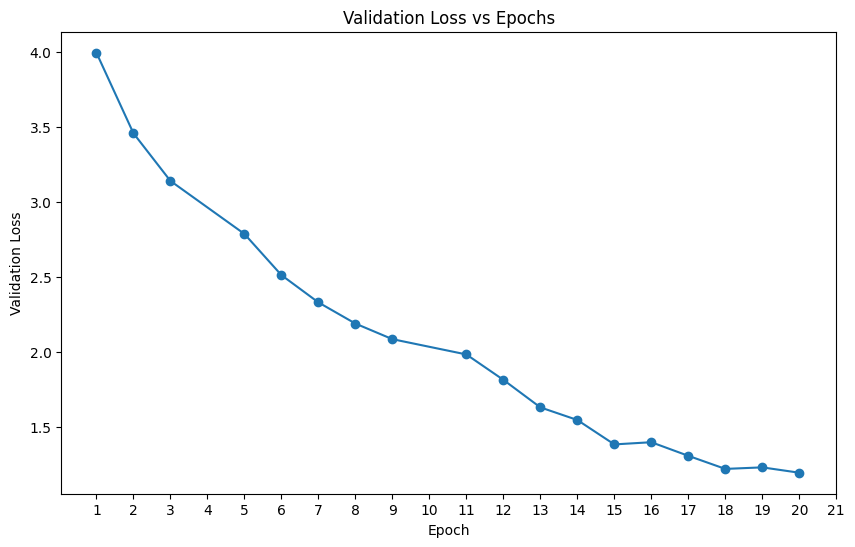

In [ ]:
history = trainer.state.log_history


epochs = []
val_losses = []

for entry in history:
    if 'eval_loss' in entry:
        epochs.append(entry.get('epoch'))
        val_losses.append(entry.get('eval_loss'))



plt.figure(figsize=(10, 6))
plt.plot(epochs, val_losses, marker='o', linestyle='-')


integer_ticks = np.arange(int(min(epochs)), int(max(epochs)) + 2)
plt.xticks(integer_ticks)


plt.title('Validation Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')



In [ ]:

trainer.args.num_train_epochs = 20  # Total including the 4 already trained


trainer.train(resume_from_checkpoint=True)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
11,1.811300,1.984182,0.641667,0.621619,0.670982,0.641667
12,1.560200,1.815017,0.658333,0.626997,0.653438,0.658333
13,1.346000,1.631358,0.658333,0.632887,0.659167,0.658333
14,1.159400,1.547233,0.687500,0.656610,0.684003,0.687500
15,0.996300,1.384524,0.720833,0.703790,0.745625,0.720833
16,0.858600,1.399116,0.708333,0.684854,0.737277,0.708333
17,0.750800,1.308462,0.712500,0.686964,0.705923,0.712500
18,0.672100,1.221205,0.737500,0.724673,0.758333,0.737500
19,0.615300,1.231492,0.733333,0.717887,0.753899,0.733333
20,0.576900,1.195773,0.741667,0.722768,0.749940,0.741667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

TrainOutput(global_step=4780, training_loss=0.5173449751722264, metrics={'train_runtime': 8203.911, 'train_samples_per_second': 4.659, 'train_steps_per_second': 0.583, 'total_flos': 1.0047581516464128e+17, 'train_loss': 0.5173449751722264, 'epoch': 20.0})

In [ ]:
model_name = f"longformer-finetuned-author-classification-samples1-epochs20"

model_save_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/model/{model_name}"
trainer.save_model(model_save_path)

In [ ]:

trainer.args.num_train_epochs = 30  # Total including the 4 already trained


trainer.train(resume_from_checkpoint=True)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
21,0.585100,1.175007,0.737500,0.719425,0.741458,0.737500
22,0.485900,1.066039,0.750000,0.731964,0.756815,0.750000
23,0.395100,1.123177,0.745833,0.738065,0.785565,0.745833
24,0.326700,1.070350,0.729167,0.707890,0.741265,0.729167
25,0.268100,1.007006,0.745833,0.730367,0.755982,0.745833
26,0.223100,0.972321,0.770833,0.757758,0.801607,0.770833
27,0.189700,0.958043,0.766667,0.749762,0.784464,0.766667
28,0.166200,0.948536,0.766667,0.750228,0.775089,0.766667
29,0.151200,0.960296,0.762500,0.746429,0.780714,0.762500
30,0.143200,0.943623,0.770833,0.755506,0.789881,0.770833


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

TrainOutput(global_step=7170, training_loss=0.09780840002509507, metrics={'train_runtime': 8167.1449, 'train_samples_per_second': 7.02, 'train_steps_per_second': 0.878, 'total_flos': 1.5071372274696192e+17, 'train_loss': 0.09780840002509507, 'epoch': 30.0})

In [ ]:
model_name = f"longformer-finetuned-author-classification-samples1-epochs30"

model_save_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/model/{model_name}"
trainer.save_model(model_save_path)

In [ ]:
history_path = os.path.join(model_save_path, "training_history.json")
with open(history_path, 'w') as f:
    json.dump(trainer.state.log_history, f)


start with loaded saved model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer


In [ ]:
model_name = f"longformer-finetuned-author-classification-samples1-epochs30"

model_save_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/model/{model_name}"

model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
tokenizer = AutoTokenizer.from_pretrained(model_save_path)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
          

In [ ]:
from transformers import TrainerCallback


In [ ]:
batch_size = 2  # Start small
gradient_accumulation_steps = 8  # This gives effective batch size of 16
logging_steps = len(train_datasets_long[1]) // batch_size

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/TheoryofML_GroupProject/model/longformer-continued-training",
    num_train_epochs=4,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error",
    gradient_accumulation_steps=4  # Added to handle larger model with smaller batches
)

# Set up the trainer using sample size 1
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,  # Reusing existing compute_metrics
    train_dataset=train_datasets_long[1],  # Using sample size 1
    eval_dataset=val_datasets_long[1],
    tokenizer=tokenizer
)

<ipython-input-35-e299261add9b>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.args.logging_strategy = "epoch"
trainer.args.log_level = "info"
trainer.args.load_best_model_at_end = True
trainer.args.metric_for_best_model = "accuracy"
trainer.args.greater_is_better = True
trainer.args.save_strategy = "epoch"  # Required for load_best_model_at_end
trainer.args.evaluation_strategy = "epoch"
trainer.args.save_total_limit = 1  # Keep only most recent checkpoint + best checkpoint


In [ ]:
# trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ny-parulekar (ny-parulekar-johns-hopkins-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.275500,1.076074,0.737500,0.722103,0.770208,0.737500
2,0.211000,1.147520,0.725000,0.723075,0.782569,0.725000
3,0.134100,1.290014,0.683333,0.662909,0.717336,0.683333
4,0.075200,1.207350,0.725000,0.711092,0.758229,0.725000
5,0.045700,1.246373,0.729167,0.712024,0.749107,0.729167
6,0.030800,1.201266,0.725000,0.711915,0.764107,0.725000
7,0.011700,1.146113,0.779167,0.769494,0.809256,0.779167
8,0.009000,1.127539,0.779167,0.768204,0.806667,0.779167
9,0.004800,1.098485,0.795833,0.786151,0.825357,0.795833


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

AttributeError: 'NoneType' object has no attribute 'save_model'

In [ ]:
trainer.args.num_train_epochs = 50
# Resume from the most recent checkpoint
trainer.train(resume_from_checkpoint=True)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,0.006300,1.100623,0.800000,0.789643,0.822917,0.800000
11,0.004700,1.136788,0.791667,0.780595,0.817083,0.791667
12,0.003200,1.166118,0.795833,0.784901,0.817500,0.795833
13,0.004100,1.165943,0.791667,0.782143,0.820208,0.791667
14,0.004300,1.188647,0.775000,0.763204,0.797292,0.775000
15,0.003700,1.169081,0.795833,0.785466,0.815417,0.795833
16,0.003200,1.201769,0.787500,0.778621,0.815208,0.787500
17,0.001900,1.217123,0.783333,0.773085,0.804375,0.783333
18,0.001700,1.213880,0.804167,0.795050,0.826042,0.804167
19,0.002600,1.216550,0.804167,0.792917,0.826458,0.804167


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

TrainOutput(global_step=11950, training_loss=0.007543315570723561, metrics={'train_runtime': 33906.502, 'train_samples_per_second': 2.818, 'train_steps_per_second': 0.352, 'total_flos': 2.511895379116032e+17, 'train_loss': 0.007543315570723561, 'epoch': 50.0})

In [ ]:
model_name = "longformer-finetuned-author-classification-samples1-epochs130"
model_save_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/model/{model_name}"
trainer.save_model(model_save_path)


In [ ]:
history_path = os.path.join(model_save_path, "training_history.json")
with open(history_path, 'w') as f:
    json.dump(trainer.state.log_history, f)


In [ ]:
#Load the training history
history_path = os.path.join(model_save_path, "training_history.json")
model_name = "longformer-finetuned-author-classification-samples1-epochs130"
model_save_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/model/{model_name}"

with open(history_path, 'r') as f:
    training_history = json.load(f)

# Extract validation accuracy from each epoch
val_metrics = [log for log in training_history if 'eval_accuracy' in log]
best_epoch = max(val_metrics, key=lambda x: x['eval_accuracy'])

print(f"Best model was from epoch {best_epoch['epoch']} with validation accuracy: {best_epoch['eval_accuracy']:.4f}")


print(f"Full metrics for best epoch:")
for key, value in best_epoch.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Best model was from epoch 45.0 with validation accuracy: 0.8083
Full metrics for best epoch:
  eval_loss: 1.3442
  eval_accuracy: 0.8083
  eval_f1: 0.7998
  eval_precision: 0.8329
  eval_recall: 0.8083
  eval_runtime: 27.0562
  eval_samples_per_second: 8.8700
  eval_steps_per_second: 4.4350
  epoch: 45.0000
  step: 10755


In [ ]:
model_name = f"longformer-finetuned-author-classification-samples1-epochs130"
model_save_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/model/{model_name}"
model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
tokenizer = AutoTokenizer.from_pretrained(model_save_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
          

In [ ]:
# Set up training arguments for evaluation only
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/TheoryofML_GroupProject/model/longformer-continued-training/bestmodel/results",
    per_device_eval_batch_size=8,  # Adjust batch size as needed
    do_train=False,
    do_eval=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
)


In [ ]:
# Evaluate on validation dataset

val_results = trainer.evaluate(eval_dataset=val_datasets_long[1])

val_results

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ny-parulekar (ny-parulekar-johns-hopkins-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 1.3442367315292358,
 'eval_model_preparation_time': 0.0038,
 'eval_accuracy': 0.8083333333333333,
 'eval_f1': 0.799781746031746,
 'eval_precision': 0.8329166666666665,
 'eval_recall': 0.8083333333333333,
 'eval_runtime': 108.4065,
 'eval_samples_per_second': 2.214,
 'eval_steps_per_second': 0.277}

In [ ]:

# # Evaluate on test dataset
# test_results = trainer.evaluate(eval_dataset=test_datasets_long[1])
# test_results

{'eval_loss': 1.5568804740905762,
 'eval_model_preparation_time': 0.0038,
 'eval_accuracy': 0.7708333333333334,
 'eval_f1': 0.7613988095238095,
 'eval_precision': 0.8054166666666667,
 'eval_recall': 0.7708333333333334,
 'eval_runtime': 109.2407,
 'eval_samples_per_second': 2.197,
 'eval_steps_per_second': 0.275}

In [ ]:
# train set
train_results = trainer.evaluate(eval_dataset=train_datasets_long[1])
train_results


{'eval_loss': 0.0009353305795229971,
 'eval_model_preparation_time': 0.0038,
 'eval_accuracy': 0.9994767137624281,
 'eval_f1': 0.9994764865430457,
 'eval_precision': 0.9994976452119309,
 'eval_recall': 0.9994767137624281,
 'eval_runtime': 870.024,
 'eval_samples_per_second': 2.196,
 'eval_steps_per_second': 0.275}

In [ ]:
results_dir = "/content/drive/MyDrive/TheoryofML_GroupProject/results/"
os.makedirs(results_dir, exist_ok=True)  # This will create the directory and any parent directories


In [ ]:
train_path = "/content/drive/MyDrive/TheoryofML_GroupProject/results/best_model_train_results.pkl"
val_path = "/content/drive/MyDrive/TheoryofML_GroupProject/results/best_model_val_results.pkl"
test_path = "/content/drive/MyDrive/TheoryofML_GroupProject/results/best_model_test_results.pkl"

save_pkl_to_drive(train_results, train_path)
save_pkl_to_drive(val_results, val_path)
save_pkl_to_drive(test_results, test_path)

 # Longformer Optuna with heirarchical agg

In [ ]:
# use 5 samples

In [ ]:
num_samples_list_long

[1, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 45, 50, 55, 60]

In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
# Optuna using existing Trainer


def objective(trial,num_train_epochs,chunk_idx,train_datasets,val_datasets,label_to_id_train,tokenizer):
    # Define the hyperparameters to optimize
    gdrive_path = "/content/drive/MyDrive/TheoryofML_GroupProject/model/longformer-optuna"
    hparams = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 8e-5, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.04, 0.09, log=True),
        "dropout": trial.suggest_float("dropout", 0.2, 0.35),
        "attention_dropout": trial.suggest_float("attention_dropout", 0.1, 0.25),
        "batch_size": trial.suggest_categorical("batch_size", [2, 3, 4, 6])
        ## should I add gradient_accumulation_steps = 8  # This gives effective batch size of 16
    }


    model_ckpt = "allenai/longformer-base-4096"

    config = AutoConfig.from_pretrained(model_ckpt)
    config.hidden_dropout_prob = hparams["dropout"]  # Regular dropout
    config.attention_probs_dropout_prob = hparams["attention_dropout"]  # Attention dropout
    config.num_labels = len(label_to_id_train)



    model = AutoModelForSequenceClassification.from_pretrained(
            model_ckpt,
            config = config
        ).to(device)


    # batch_size = 64
    # logging_steps = len(train_datasets[30]) // batch_size
    model_name = f"{model_ckpt}-finetuned-author-classification-hyp_samples5"

    trial_output_dir = os.path.join(gdrive_path, f"{model_name}-trial-{trial.number}")
    os.makedirs(trial_output_dir, exist_ok=True)

    # Set up training arguments with trial hyperparameters
    training_args = TrainingArguments(
        output_dir=trial_output_dir,
        num_train_epochs=num_train_epochs,
        learning_rate=hparams["learning_rate"],
        per_device_train_batch_size=hparams["batch_size"],
        per_device_eval_batch_size=hparams["batch_size"],
        gradient_accumulation_steps =8,
        warmup_ratio=0.1,
        weight_decay=hparams["weight_decay"],
        eval_strategy="epoch",
        disable_tqdm=False,
        # logging_steps=logging_steps,
        push_to_hub=False,
        log_level="error",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False  # We want to minimize validation loss
    )

    # Set up trainer for this trial
    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_datasets[chunk_idx],
        eval_dataset=val_datasets[chunk_idx],
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    try:
        # Train the model with error handling
        trainer.train()
    except RuntimeError as e:
        if 'CUDA out of memory' in str(e):
            print(f"Pruned trial {trial.number} due to OOM error with batch size {hparams['batch_size']}")
            # Cleanup before pruning
            del model, trainer
            clear_memory()

            raise optuna.exceptions.TrialPruned()

        raise


    trial_results_path = os.path.join(trial_output_dir, "results.txt")


    eval_result = trainer.evaluate()
    loss_value = eval_result["eval_loss"]


    del model, trainer
    clear_memory()

    return loss_value




In [ ]:
model_ckpt = "allenai/longformer-base-4096"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
study_name = "longformer-optuna_study.pkl"
gdrive_study_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/{study_name}"


In [ ]:

pruner = MedianPruner(n_startup_trials=1, n_warmup_steps=5)
study = optuna.create_study(direction="minimize", pruner=pruner)

study.optimize(functools.partial(objective, num_train_epochs=5,
                                 chunk_idx=5,
                                 train_datasets=train_datasets_long,
                                 val_datasets=val_datasets_long,
                                 label_to_id_train=label_to_id_train_long,
                                 tokenizer = tokenizer), n_trials=8,callbacks=[save_callback])



[I 2025-04-27 00:15:00,831] A new study created in memory with name: no-name-271a26c0-7706-49bb-84af-e7956c5b2a07
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-57-4ef81f181bfe>:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more 

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ny-parulekar (ny-parulekar-johns-hopkins-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Pruned trial 0 due to OOM error with batch size 6


[I 2025-04-27 00:15:35,776] Trial 0 pruned. 
<ipython-input-57-4ef81f181bfe>:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,2.679962,0.375833,0.329217,0.420702,0.375833
2,3.139200,1.464564,0.656667,0.639814,0.699792,0.656667
3,3.139200,1.124935,0.707500,0.702428,0.760015,0.707500
4,1.074700,0.898964,0.755000,0.749225,0.792651,0.755000
5,0.374400,0.819907,0.774167,0.771082,0.806273,0.774167


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[I 2025-04-27 05:44:51,335] Trial 1 finished with value: 0.8199069499969482 and parameters: {'learning_rate': 7.752058585728844e-05, 'weight_decay': 0.05436138210612797, 'dropout': 0.23912838601755876, 'attention_dropout': 0.2014314282753002, 'batch_size': 4}. Best is trial 1 with value: 0.8199069499969482.
<ipython-input-57-4ef81f181bfe>:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,4.188300,3.277195,0.237500,0.158646,0.180244,0.237500
2,3.080900,2.356437,0.452500,0.414704,0.499429,0.452500
3,2.277100,1.688764,0.631667,0.614709,0.659160,0.631667
4,1.704900,1.689574,0.584167,0.571613,0.660010,0.584167
5,1.088600,1.550283,0.615000,0.599396,0.683686,0.615000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-27 11:29:19,956] Trial 2 finished with value: 1.5502828359603882 and parameters: {'learning_rate': 3.241519218020659e-05, 'weight_decay': 0.05059263414707933, 'dropout': 0.3136801271279689, 'attention_dropout': 0.20095131733575528, 'batch_size': 2}. Best is trial 1 with value: 0.8199069499969482.
<ipython-input-57-4ef81f181bfe>:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,3.118524,0.290833,0.216159,0.242481,0.290833
2,3.504800,2.176310,0.510833,0.472922,0.541335,0.510833
3,3.504800,1.590550,0.645833,0.635427,0.699872,0.645833
4,1.820300,1.324780,0.673333,0.667163,0.755095,0.673333
5,1.035500,1.254018,0.692500,0.685927,0.748619,0.692500


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[I 2025-04-27 16:58:12,257] Trial 3 finished with value: 1.2540183067321777 and parameters: {'learning_rate': 5.4299336387744425e-05, 'weight_decay': 0.07290542448973412, 'dropout': 0.3095080513935409, 'attention_dropout': 0.24739611592131955, 'batch_size': 4}. Best is trial 1 with value: 0.8199069499969482.
<ipython-input-57-4ef81f181bfe>:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Pruned trial 4 due to OOM error with batch size 6


[I 2025-04-27 16:58:14,596] Trial 4 pruned. 
<ipython-input-57-4ef81f181bfe>:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Pruned trial 5 due to OOM error with batch size 6


[I 2025-04-27 16:58:16,854] Trial 5 pruned. 
<ipython-input-57-4ef81f181bfe>:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Pruned trial 6 due to OOM error with batch size 6


[I 2025-04-27 16:58:19,104] Trial 6 pruned. 
<ipython-input-57-4ef81f181bfe>:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,4.209600,3.526403,0.221667,0.179157,0.254954,0.221667
2,3.209300,2.768372,0.381667,0.333734,0.389446,0.381667
3,2.510600,2.392486,0.452500,0.415023,0.523068,0.452500
4,2.041400,2.161755,0.510000,0.485631,0.607346,0.510000
5,1.530200,2.101857,0.510833,0.485836,0.641645,0.510833


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:


try:
    trials_df = study.trials_dataframe()
    csv_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/longformer_trials.csv"
    trials_df.to_csv(csv_path)
    print(f"Detailed trial results saved to: {csv_path}")
except Exception as e:
    print(f"Error saving trials dataframe: {e}")


print("Best trial:")
trial = study.best_trial
print(f"  Value (Validation Loss): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
mode_ckpt

NameError: name 'mode_ckpt' is not defined

In [ ]:
# load best model and do heirarchical agg

In [ ]:
# 1. Load the saved study
study_name = "longformer-optuna_study.pkl"
gdrive_study_path = f"/content/drive/MyDrive/TheoryofML_GroupProject/{study_name}"

# Load the study object
study = joblib.load(gdrive_study_path)

# 2. Get the best trial number
best_trial_number = study.best_trial.number
print(f"Best trial number: {best_trial_number}")
print(f"Best validation loss: {study.best_value}")
print("Best hyperparameters:")
for param_name, param_value in study.best_params.items():
    print(f"  {param_name}: {param_value}")

#

Best trial number: 1
Best validation loss: 0.8199069499969482
Best hyperparameters:
  learning_rate: 7.752058585728844e-05
  weight_decay: 0.05436138210612797
  dropout: 0.23912838601755876
  attention_dropout: 0.2014314282753002
  batch_size: 4


In [ ]:
#load best model
gdrive_path = "/content/drive/MyDrive/TheoryofML_GroupProject/model/longformer-optuna"
model_ckpt = "allenai/longformer-base-4096"
model_name = f"{model_ckpt}-finetuned-author-classification-hyp_samples5"
best_model_dir = f"{gdrive_path}/{model_name}-trial-{best_trial_number}"



checkpoints = [d for d in os.listdir(best_model_dir) if d.startswith("checkpoint-")]
if checkpoints:
    # Sort checkpoints to find the latest one
    checkpoints.sort(key=lambda x: int(x.split("-")[1]))
    best_checkpoint = os.path.join(best_model_dir, checkpoints[-1])
    print(f"Loading best model from: {best_checkpoint}")
else:
    # If no checkpoints found, use the main directory
    best_checkpoint = best_model_dir
    print(f"No checkpoints found, loading from: {best_checkpoint}")


Loading best model from: /content/drive/MyDrive/TheoryofML_GroupProject/model/longformer-optuna/allenai/longformer-base-4096-finetuned-author-classification-hyp_samples5-trial-1/checkpoint-1500


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(best_checkpoint)
num_labels = len(label_to_id_train_long)
# model = AutoModelForSequenceClassification.from_pretrained(
#     best_checkpoint,
#     num_labels=num_labels
# ).to(device)


NameError: name 'device' is not defined

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    best_checkpoint,
    num_labels=num_labels
).to(device)


In [ ]:
# heir agg

In [ ]:
training_args = TrainingArguments(
output_dir="/content/drive/MyDrive/TheoryofML_GroupProject/model/longformer-optuna/best_heir_eval",
per_device_eval_batch_size=4,
disable_tqdm=False,
log_level="error",
remove_unused_columns=False
)

trainer = DocumentTracker( #defined before in the heir section
model=model,
args=training_args,
compute_metrics=compute_metrics,
tokenizer=tokenizer,
data_collator=CustomDataCollator() #defined before in the heir section

)

<ipython-input-40-e120f1da83ce>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DocumentTracker.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [ ]:
results_val = trainer.predict(val_datasets_long[5])


Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'global_attention_mask', 'document_id'])
Found document_id in batch, length: 4
Buffer now has 4 document IDs


Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'global_attention_mask', 'document_id'])
Found document_id in batch, length: 4
Buffer now has 8 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'global_attention_mask', 'document_id'])
Found document_id in batch, length: 4
Buffer now has 12 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'global_attention_mask', 'document_id'])
Found document_id in batch, length: 4
Buffer now has 16 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'global_attention_mask', 'document_id'])
Found document_id in batch, length: 4
Buffer now has 20 document IDs
Input keys in prediction_step: dict_keys(['input_ids', 'attention_mask', 'labels', 'global_attention_mask', 'document_id'])
Found document_id in batch, length: 4
Buffer now has 24 document IDs
Input keys in prediction_step: dict_

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ny-parulekar (ny-parulekar-johns-hopkins-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
predictions = results_val['predictions'] # these are raw logits

document_ids = results_val['document_ids']


metrics, prediction_results = evaluate_document_aggregation_strategies(
predictions,
document_ids,
val_datasets_long[5]
)


Metrics by aggregation strategy:

MAX:
  accuracy: 0.8333
  f1: 0.8259
  precision: 0.8714
  recall: 0.8333

PROB_SUM:
  accuracy: 0.8250
  f1: 0.8187
  precision: 0.8611
  recall: 0.8250

PROB_PRODUCT:
  accuracy: 0.8208
  f1: 0.8152
  precision: 0.8558
  recall: 0.8208


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# best model is DistillBERT[30] with prob_sum aggregation  !!!